# Long Notebook - Active

#### Emil B. Berglund - 529222 & Louis H. H. Linnerud - 539305, Team: Få d rett i git'ern

#### Table of contents:
0. Setup

1. Exploratory data analysis

2. Feature Engineering
    - Build features
        - Pure grunnkrets features
        - Income features
        - Age / Population features
        - Household features
        - Bus features
        - store based features
    - Combine features into one frame
    - inspect features 
<br>
<br>
3. Models/Predictors
    - LightGBM
    - CatBoost
    - XGBoost
    - Random Forest Regressor
    - H2O AutoML
<br>
<br>
4. Model Interpretations
    - Parameter importance
    - feature importance



___

# ___________ _0. Setup_ ___________

In [147]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import seaborn as sns
import sklearn.metrics as metrics
import sklearn.ensemble as ensemble
import optuna
import lightgbm as lgb
import catboost as cb
import xgboost as xg
import featuretools as ft
import category_encoders as ce
import shap
import h2o
from h2o.automl import H2OAutoML
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import log_loss, mean_squared_error, mean_squared_log_error
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from verstack import LGBMTuner, MeanTargetEncoder, OneHotEncoder
from sklearn.neighbors import BallTree, KDTree




#from pandas_profiling import ProfileReport

In [148]:
def writeResultToFile(test_data, pred_data, nameOfFile='namelessSubmission'):
    submission = pd.DataFrame()
    submission['id'] = test_data['store_id']
    submission['predicted'] = np.asarray(pred_data)
    submission.to_csv('submissionFiles/'+ nameOfFile+'.csv', index=False)
    

In [149]:
def rmsle(y_true, y_pred):
    return mean_squared_log_error(y_true, y_pred)**0.5

___

# ___________ _1. Exploratory Data Analysis_ ___________


### Domain Knowledge

Retailers obviously earn their revenue from sales, different retailers sell different products to different customers. Different products have different margins and number of sales, directly impacting the revenue. Number of sales most likely have a high correlation with number of costumers, areas with a high population density will therefor most likely have a higher number of customers, impacting number of sales and then impacting the revenue. Therefor retailer type and geographical position most likely have a high impact on revenue. Only knowing those two attributes can be a good pin pointer, but not necessary enough as described in this article: https://carto.com/blog/retail-revenue-prediction-data-science/. Area infrastructure, retailer reputation, market competition, inventory managements, customer type, sales strategy and a lot more factors impact revenue and makes this problem complex. further reading on some of these factors: https://smallbusiness.chron.com/calculate-percentage-profit-markups-business-60099.html


### Is the data intuitiv?

As can be seen below, data is organized in rows, where each row represents a single retailer with its relevant attributes and revenue. The stores train, extra and test data is intuitiv.

The different grunnkrets data was not super intuitv before some exploration was done, the same grunnkrets_id appeard more than once, but we shortly realized that this is because the measurment (example: average income) is done twice, once in 2015 and once in 2016.

In [150]:
stores_train = pd.read_csv('data/stores_train.csv')


In [151]:
stores_train.head()

,store_id,year,store_name,plaace_hierarchy_id,sales_channel_name,grunnkrets_id,address,lat,lon,chain_name,mall_name,revenue
0,983540538-974187930-44774,2016,MCDONALD'S BRAGERNES TORG MAGASINET,1.1.1.0,Hamburger restaurants,6020303,BRAGERNES TORG 13,59.743104,10.204928,MCDONALDS,Magasinet Drammen,17.998
1,987074191-973117734-44755,2016,MCDONALD'S KLINGENBERGGATA,1.1.1.0,Hamburger restaurants,3010306,NaN,59.913759,10.734031,MCDONALDS,NaN,23.828
2,984890265-981157303-64491,2016,BURGER KING HØNEFOSS,1.1.1.0,Hamburger restaurants,6050102,KONG RINGS GATE 1,60.164751,10.254656,BURGER KING,Kuben Hønefoss,16.099
3,914057442-992924179-126912,2016,BURGER KING GLASSHUSPASSASJEN,1.1.1.0,Hamburger restaurants,18040102,STORGATA 12,67.283669,14.379796,BURGER KING,Glasshuspassasjen,9.296
4,913018583-913063538-668469,2016,BURGER KING TILLERTORGET,1.1.1.0,Hamburger restaurants,16017414,NaN,63.358068,10.374832,BURGER KING,Tillertorget,4.528


In [54]:
stores_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12859 entries, 0 to 12858
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   store_id             12859 non-null  object 
 1   year                 12859 non-null  int64  
 2   store_name           12859 non-null  object 
 3   plaace_hierarchy_id  12859 non-null  object 
 4   sales_channel_name   12859 non-null  object 
 5   grunnkrets_id        12859 non-null  int64  
 6   address              11085 non-null  object 
 7   lat                  12859 non-null  float64
 8   lon                  12859 non-null  float64
 9   chain_name           3737 non-null   object 
 10  mall_name            2280 non-null   object 
 11  revenue              12859 non-null  float64
dtypes: float64(3), int64(2), object(7)
memory usage: 1.2+ MB


In [152]:
stores_train.describe()

,year,grunnkrets_id,lat,lon,revenue
count,12859.0,1.285900e+04,12859.000000,12859.000000,12859.000000
mean,2016.0,9.338697e+06,61.212166,9.995425,8.220683
std,0.0,5.788875e+06,2.965672,3.793565,15.377130
min,2016.0,1.010105e+06,57.994443,4.625889,0.000000
25%,2016.0,3.014208e+06,59.421935,7.284691,1.195000
50%,2016.0,9.065213e+06,59.939017,10.407916,3.374000
75%,2016.0,1.449011e+07,62.116531,10.848180,7.996000
max,2016.0,2.030031e+07,71.098287,31.118935,219.599000


In [56]:
#report = ProfileReport(stores_train)
#report

### Explore individual features and pairs and groups

Explore revenue based on store type

In [153]:
plaace_hierarchy = pd.read_csv('data/plaace_hierarchy.csv')
stores_with_hierarchy = stores_train.merge(plaace_hierarchy, how='left', on='plaace_hierarchy_id')

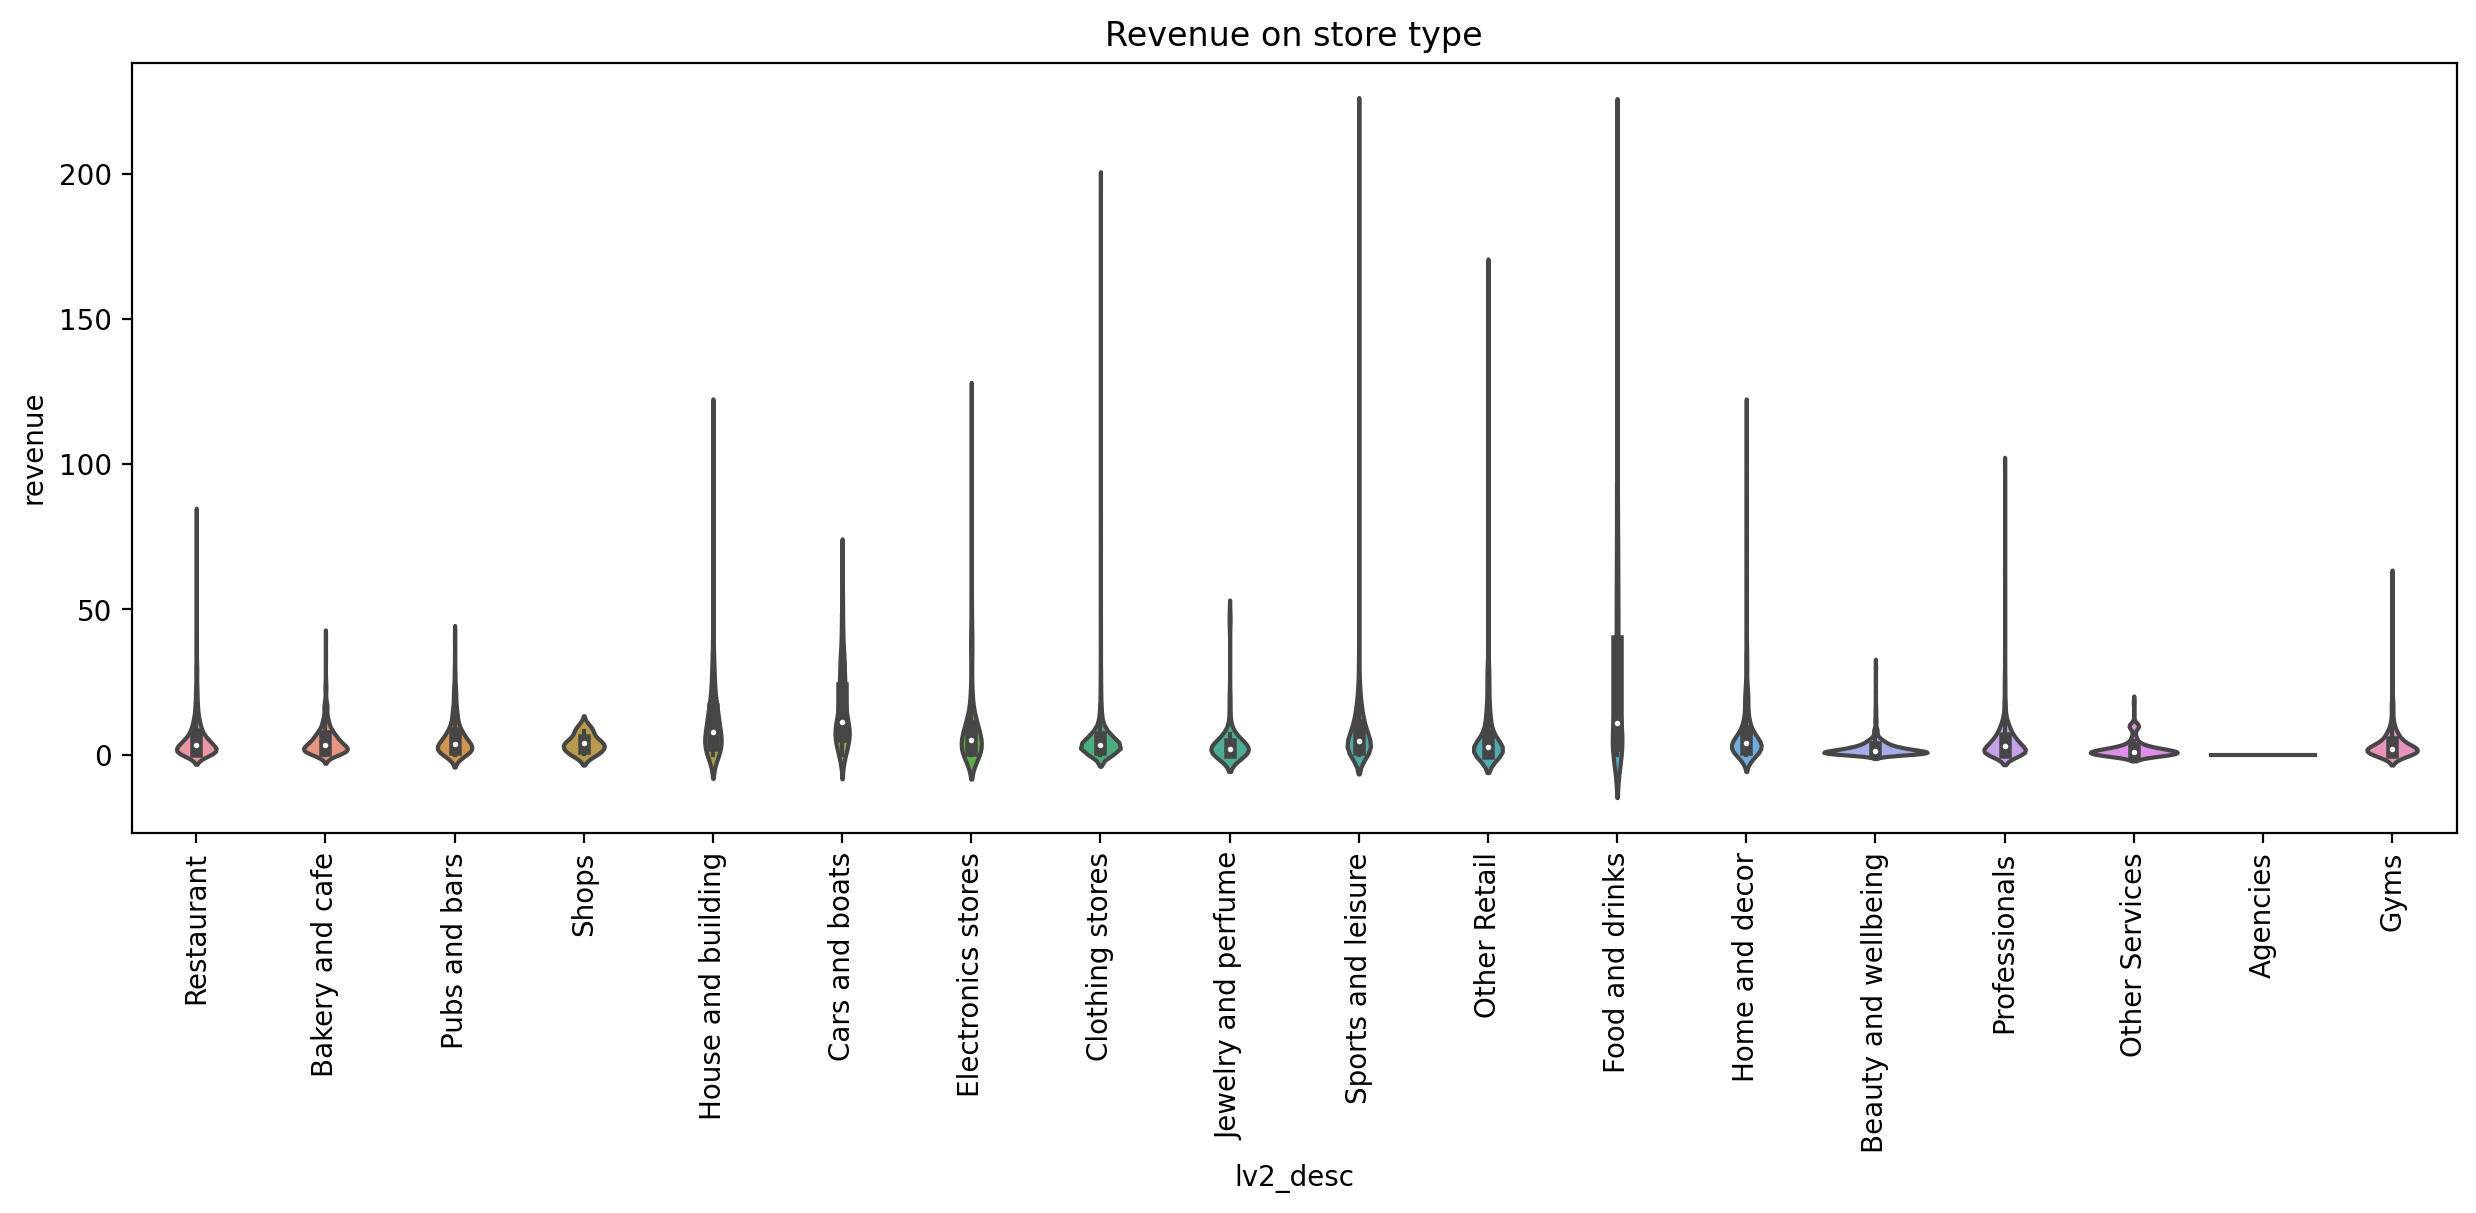

In [58]:
plt.figure(figsize=(15,5), dpi=200)
plt.xticks(rotation=90)
sns.violinplot(x='lv2_desc',y='revenue',data=stores_with_hierarchy).set_title("Revenue on store type")
plt.show()

further exploration of agencie store type

In [59]:
stores_with_hierarchy[stores_with_hierarchy["lv2_desc"]=="Agencies"]

,store_id,year,store_name,plaace_hierarchy_id,sales_channel_name_x,grunnkrets_id,address,lat,lon,chain_name,...,revenue,sales_channel_name_y,lv1,lv1_desc,lv2,lv2_desc,lv3,lv3_desc,lv4,lv4_desc
12442,915797512-915815782-782390,2016,RUUKKI BUILDING COMPONENTS AS,3.5.3.0,Advertising agencies,3014005,ØSTRE AKER VEI 219,59.948112,10.883745,NaN,...,0.0,Advertising agencies,3,Services,3.5,Agencies,3.5.3,Advertising agencies,3.5.3.0,Advertising agencies


Further exploration of "Food and drink" type stores


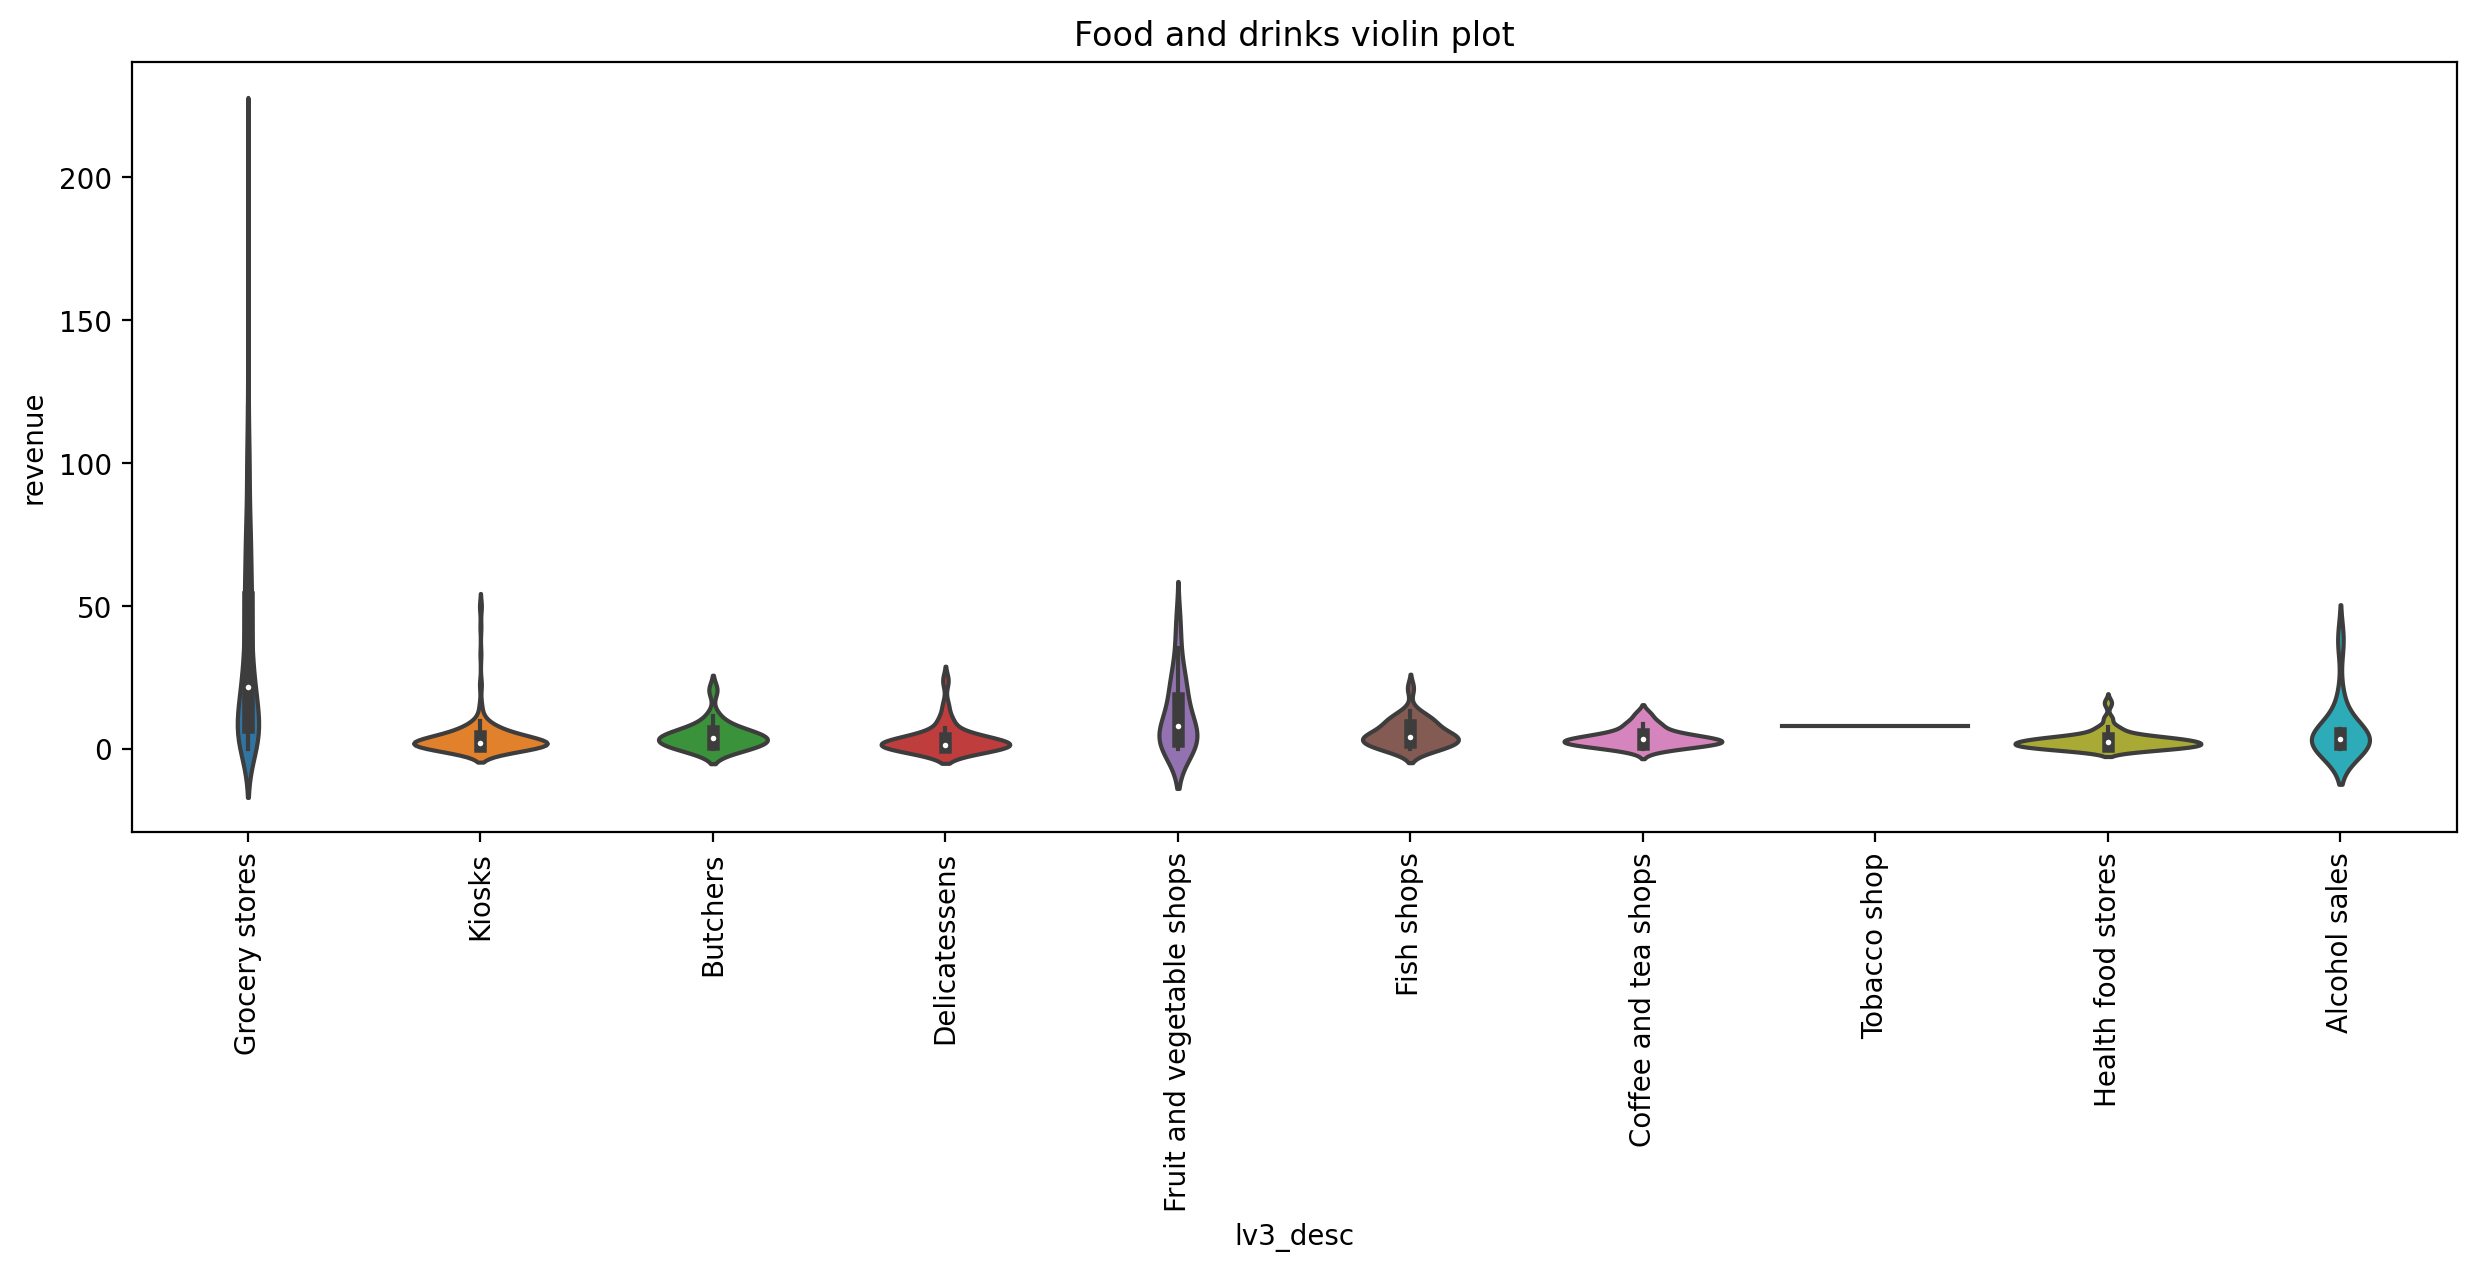

In [60]:
plt.figure(figsize=(15,5), dpi=200)
sns.violinplot(x='lv3_desc',y='revenue',data=stores_with_hierarchy[stores_with_hierarchy["lv2_desc"]=="Food and drinks"]).set_title("Food and drinks violin plot")
plt.xticks(rotation=90)
plt.show()

Explore retailers with NaN, 0 or negative revenue

In [61]:
stores_with_hierarchy[stores_with_hierarchy["revenue"]==0.0].describe()

,year,grunnkrets_id,lat,lon,revenue,lv1,lv2
count,217.0,2.170000e+02,217.000000,217.000000,217.0,217.000000,217.000000
mean,2016.0,7.609318e+06,60.671650,10.007769,0.0,1.788018,2.188940
std,0.0,5.511516e+06,2.432534,3.006842,0.0,0.594141,0.758634
min,2016.0,1.040301e+06,58.029041,5.035586,0.0,1.000000,1.100000
25%,2016.0,3.010401e+06,59.559941,8.591472,0.0,1.000000,1.100000
50%,2016.0,6.020802e+06,59.919065,10.620743,0.0,2.000000,2.400000
75%,2016.0,1.201012e+07,60.394286,10.814440,0.0,2.000000,2.800000
max,2016.0,2.030030e+07,69.890997,30.043801,0.0,3.000000,3.600000


In [62]:
stores_with_hierarchy[stores_with_hierarchy["revenue"] < 0.0].describe()

,year,grunnkrets_id,lat,lon,revenue,lv1,lv2
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
stores_with_hierarchy[stores_with_hierarchy["revenue"]== np.nan].describe()

,year,grunnkrets_id,lat,lon,revenue,lv1,lv2
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN


All retailers and their cooresponding revenue, the plot is to visually check for outliers, clearly there are som outliers as can be seen in the long tail to the right of the major distribution.
The data is clearly positively skewed, confirmed by the skew number printed above the plot. Log transforming the revenue gives a prettier and much better distribution to work with

raw data skew: 4.759845139718512
log transform skew: 0.6787855811421601


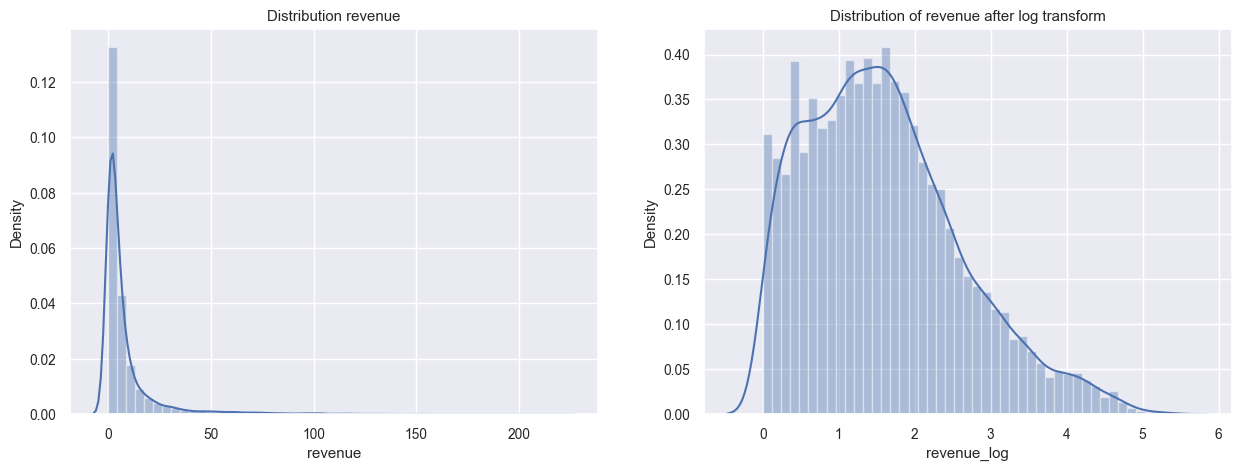

In [154]:
rev_log = pd.DataFrame()
rev_log['revenue_log'] = np.log1p(stores_train['revenue'])

fig, (ax1, ax2) = plt.subplots(figsize=(15, 5), ncols=2, dpi=100)
sns.distplot(stores_train['revenue'], ax=ax1);
ax1.set_title('Distribution revenue');
sns.distplot(rev_log['revenue_log'], ax=ax2);
ax2.set_title('Distribution of revenue after log transform');

print(f"raw data skew: {stores_train['revenue'].skew()}")
print(f"log transform skew: {rev_log['revenue_log'].skew()}")

### Cleaning

Remove columns function - example: year is a const value and has no effect on the end result

In [155]:
def remove_columns(dataSet, columns):
    for column in columns:
        dataSet.drop(column, axis=1, inplace=True)


In [156]:
remove_columns(stores_train,['year'])
stores_train.head()

,store_id,store_name,plaace_hierarchy_id,sales_channel_name,grunnkrets_id,address,lat,lon,chain_name,mall_name,revenue
0,983540538-974187930-44774,MCDONALD'S BRAGERNES TORG MAGASINET,1.1.1.0,Hamburger restaurants,6020303,BRAGERNES TORG 13,59.743104,10.204928,MCDONALDS,Magasinet Drammen,17.998
1,987074191-973117734-44755,MCDONALD'S KLINGENBERGGATA,1.1.1.0,Hamburger restaurants,3010306,NaN,59.913759,10.734031,MCDONALDS,NaN,23.828
2,984890265-981157303-64491,BURGER KING HØNEFOSS,1.1.1.0,Hamburger restaurants,6050102,KONG RINGS GATE 1,60.164751,10.254656,BURGER KING,Kuben Hønefoss,16.099
3,914057442-992924179-126912,BURGER KING GLASSHUSPASSASJEN,1.1.1.0,Hamburger restaurants,18040102,STORGATA 12,67.283669,14.379796,BURGER KING,Glasshuspassasjen,9.296
4,913018583-913063538-668469,BURGER KING TILLERTORGET,1.1.1.0,Hamburger restaurants,16017414,NaN,63.358068,10.374832,BURGER KING,Tillertorget,4.528


function for removing retailers with 0 revenue [not used later in the notebook]

In [157]:
def remove_retailers_with_0_revenue(dataSet):
    dataSet.drop(dataSet[dataSet['revenue']==0.0].index, inplace=True)

Removing outliers

function below is for capping outliers in each store type category

In [158]:
def quantile_storeType_vs_revenue(stores, lower, upper):
    col_idx = stores.columns.get_loc('revenue')
    for store_type in stores['plaace_hierarchy_id'].unique():
        data = stores[stores['plaace_hierarchy_id']==store_type]
        upper_treshold = data['revenue'].quantile(upper)
        lower_treshold = data['revenue'].quantile(lower)
        #stores.drop(stores[(stores['plaace_hierarchy_id']==store_type) & (stores['revenue']>upper_treshold)].index, inplace=True)
        #stores.drop(stores[(stores['plaace_hierarchy_id']==store_type) & (stores['revenue']<lower_treshold)].index, inplace=True)
        
        stores.iloc[stores[(stores['plaace_hierarchy_id']==store_type) & (stores['revenue']>upper_treshold)].index,[col_idx]] = upper_treshold
        stores.iloc[stores[(stores['plaace_hierarchy_id']==store_type) & (stores['revenue']<lower_treshold)].index,[col_idx]] = lower_treshold
        
    

Plotting all retailers based on storetype before and after trimming to visually check that outliers actually has been removed. you can see the difference in that the long upright tail in the violins are snipped of

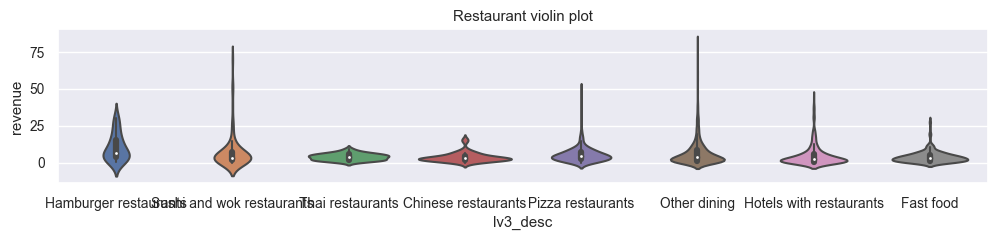

In [159]:
for store_type in stores_with_hierarchy['lv2_desc'].unique():
    plt.figure(figsize=(12,2))
    sns.violinplot(x='lv3_desc',y='revenue',data=stores_with_hierarchy[stores_with_hierarchy["lv2_desc"]==store_type]).set_title(f"{store_type} violin plot")
    plt.show()
    break #comment out for exploring more store types

In [70]:
quantile_storeType_vs_revenue(stores_train,0.05,0.86)

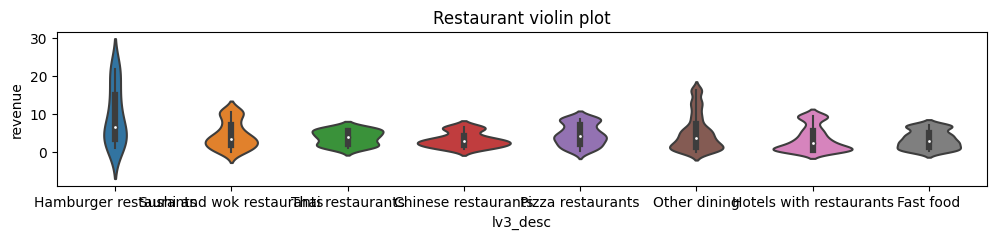

In [71]:
plaace_hierarchy = pd.read_csv('data/plaace_hierarchy.csv')
stores_with_hierarchy = stores_train.merge(plaace_hierarchy, how='left', on='plaace_hierarchy_id')
for store_type in stores_with_hierarchy['lv2_desc'].unique():
    plt.figure(figsize=(12,2))
    sns.violinplot(x='lv3_desc',y='revenue',data=stores_with_hierarchy[stores_with_hierarchy["lv2_desc"]==store_type]).set_title(f"{store_type} violin plot")
    plt.show()
    break #comment out for exploring more store types

Is combining outlier removal and log transforming revenue a good combo?

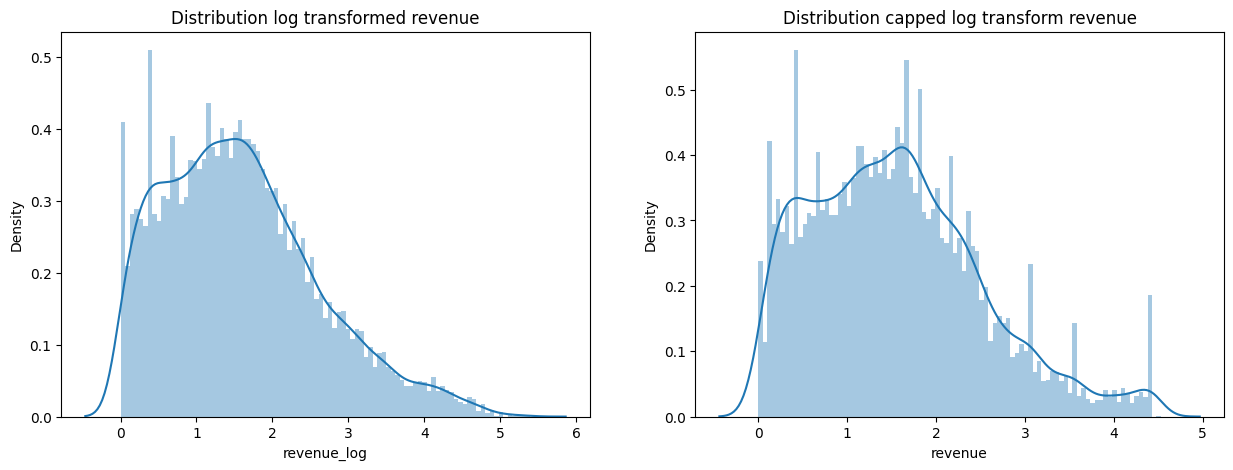

In [72]:
stores_train = pd.read_csv('data/stores_train.csv')
rev_log = pd.DataFrame()
rev_log['revenue_log'] = np.log1p(stores_train['revenue'])

rev_capped_log = stores_train.copy()
quantile_storeType_vs_revenue(rev_capped_log, 0.03, 0.90)
rev_capped_log['revenue'] = np.log1p(rev_capped_log['revenue'])

fig, (ax1, ax2) = plt.subplots(figsize=(15, 5), ncols=2, dpi=100)
sns.distplot(rev_log['revenue_log'], ax=ax1, bins=91);
ax1.set_title('Distribution log transformed revenue');
sns.distplot(rev_capped_log['revenue'], ax=ax2, bins=91);
ax2.set_title('Distribution capped log transform revenue');

Quantiling the data improved our predictions greatly in the beginning of the project, but we saw that it didnt have a noticable impact after we began exploring log transform, the plot above shows that quantiling does not improve distribution combined with log transform

#### compare store locations in test and train set

In [73]:
stores_train = pd.read_csv('data/stores_train.csv')
stores_test = pd.read_csv('data/stores_test.csv')

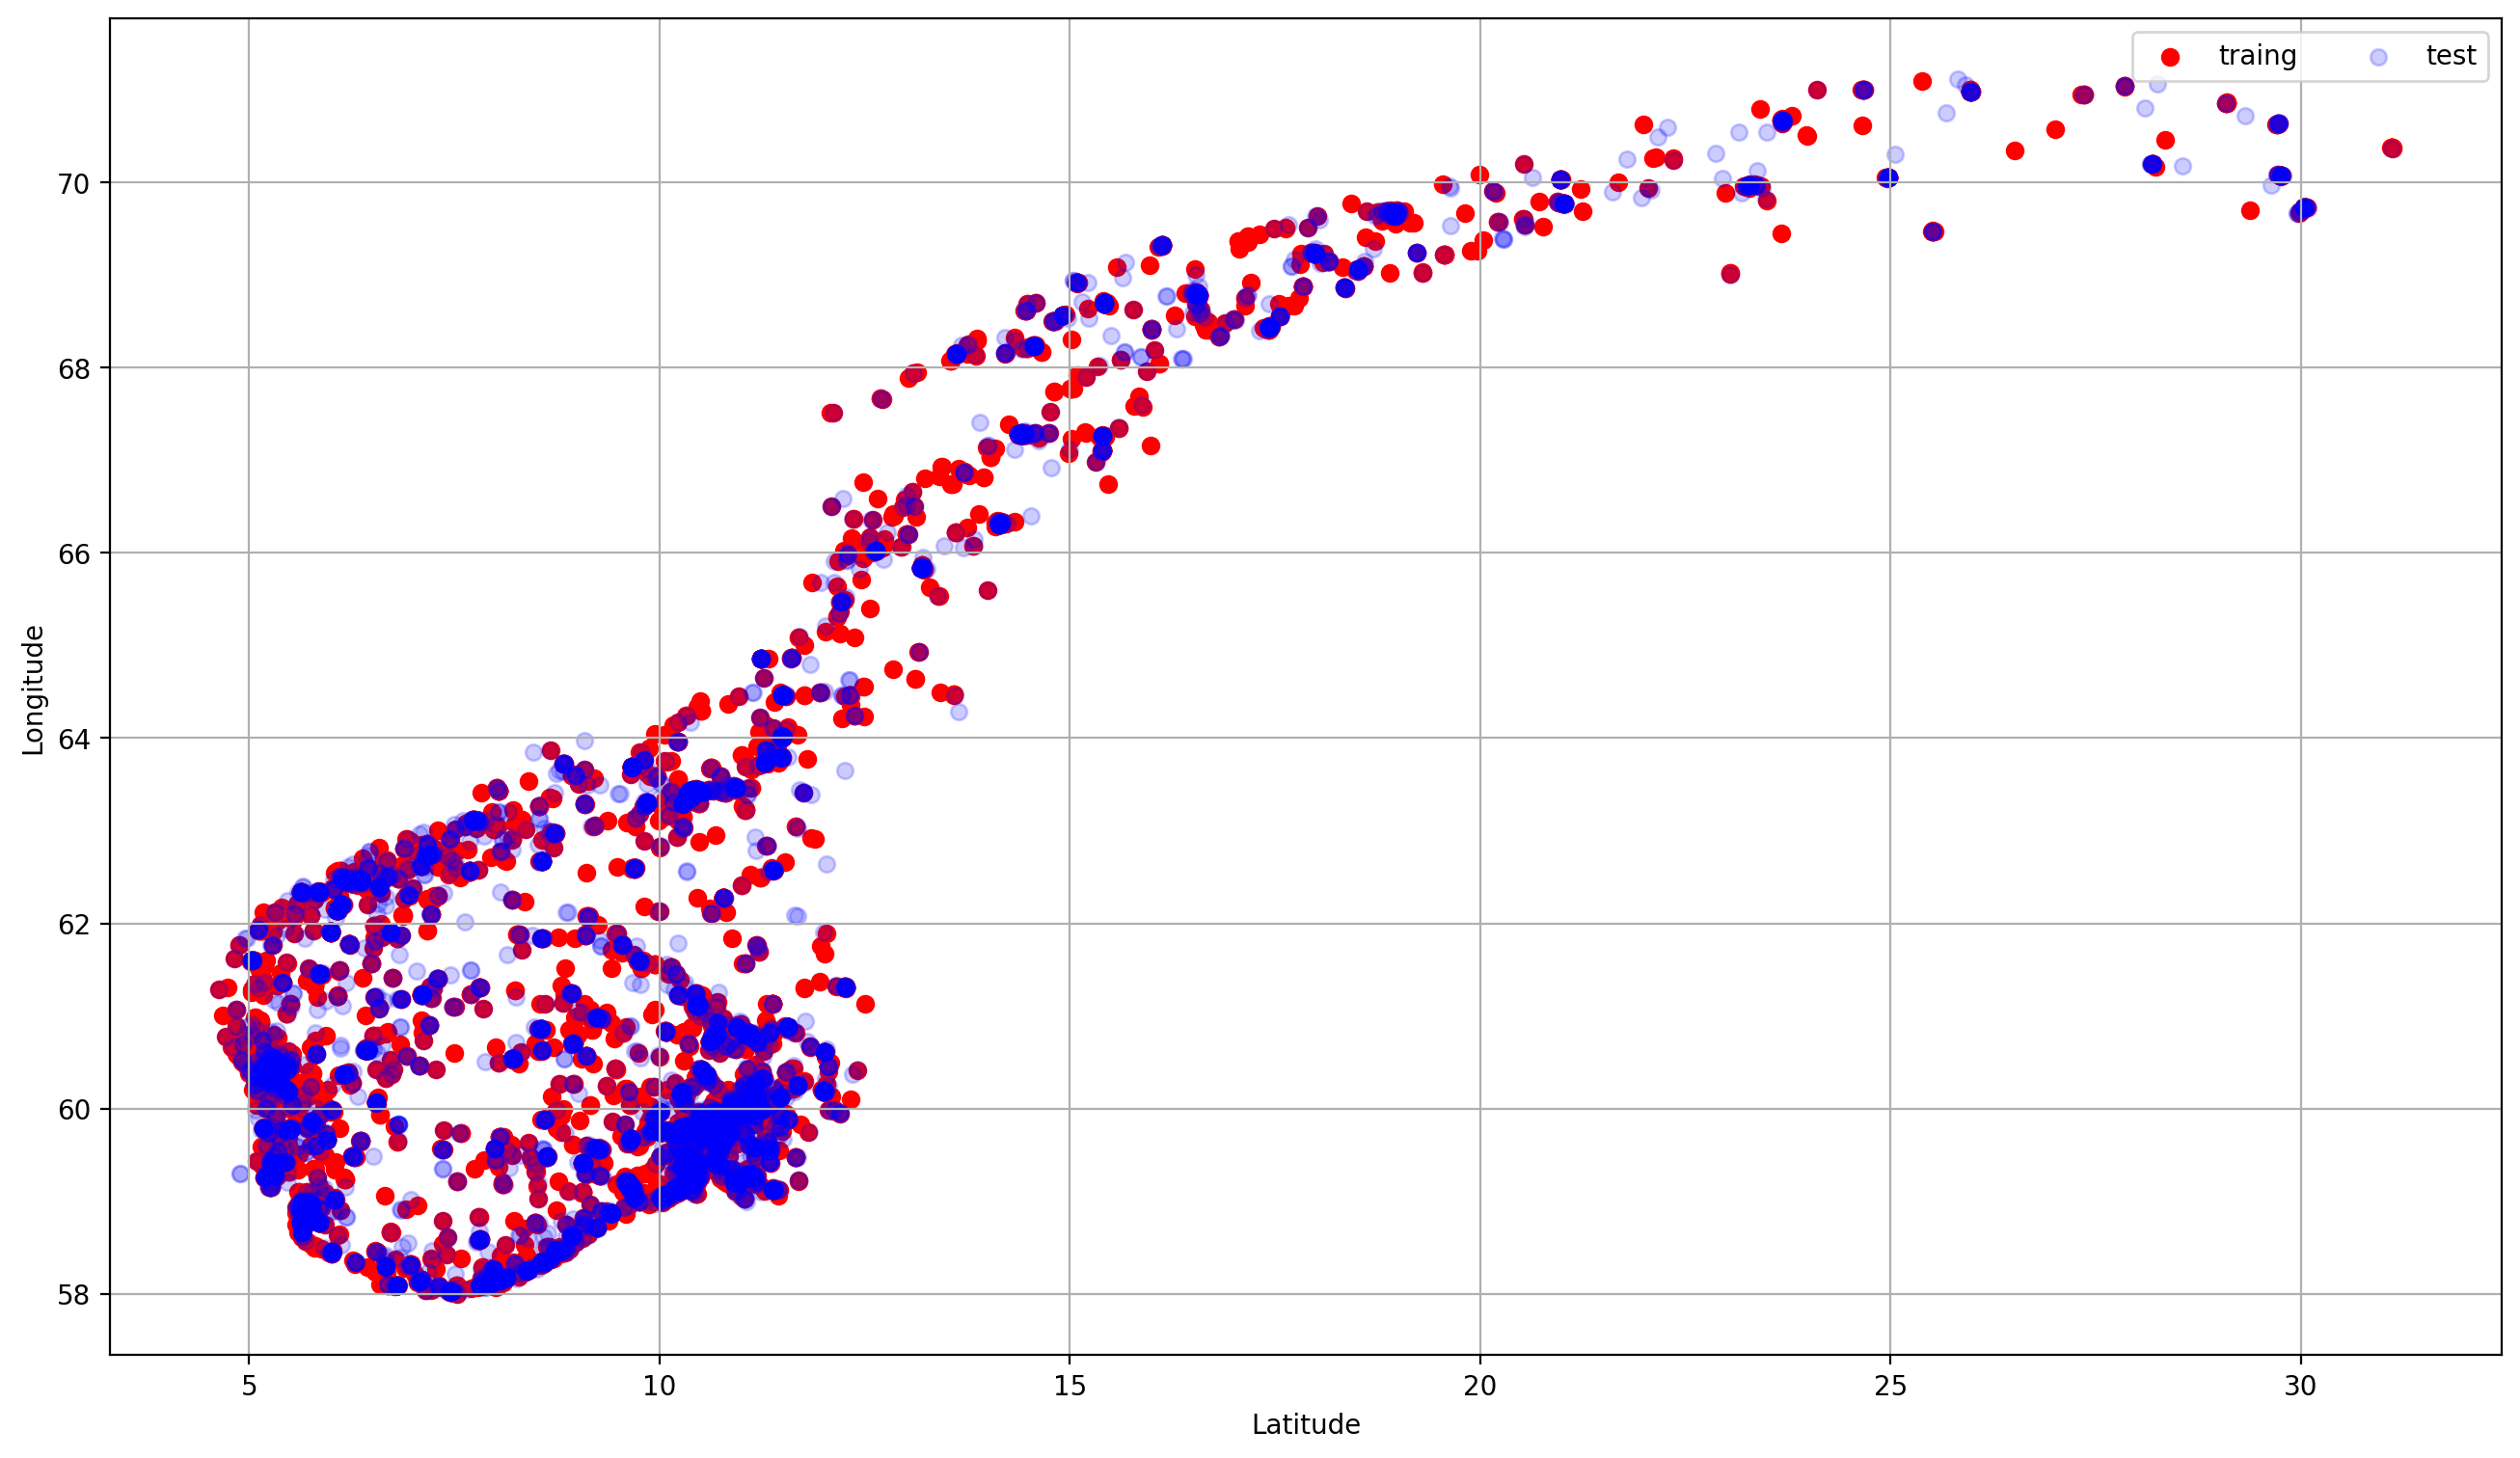

In [74]:
plt.figure(figsize=(16,9), dpi=200)
plt.scatter(stores_train['lon'],stores_train['lat'], label="traing",color='red')
plt.scatter(stores_test['lon'], stores_test['lat'], alpha=0.2, label="test", color="blue")
plt.legend(fontsize=10,ncol=2)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.grid()
plt.show()



position and revenue plot for train set

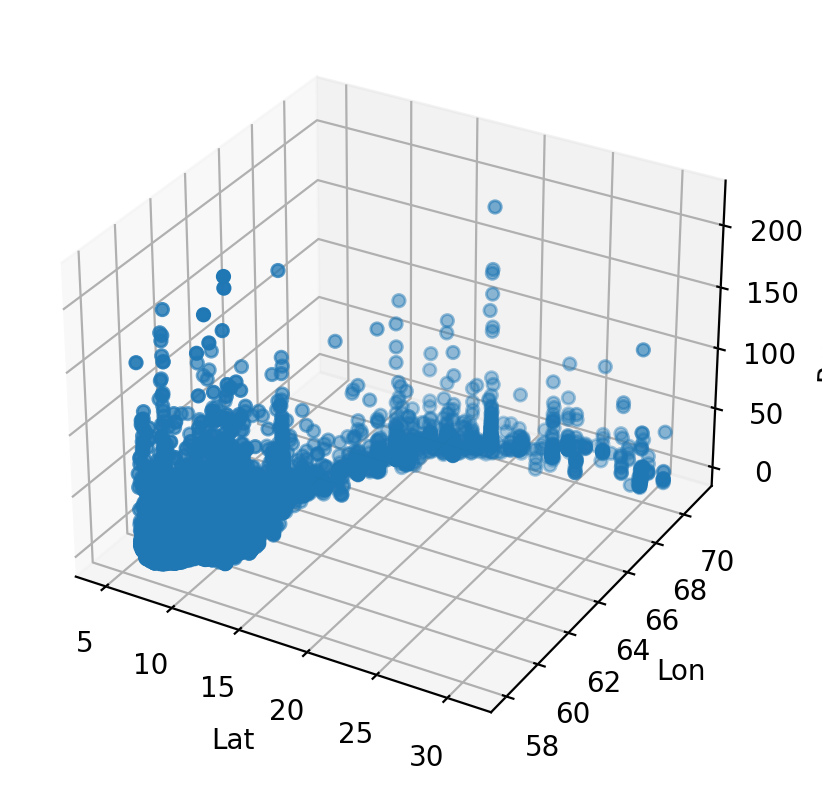

In [75]:
fig = plt.figure(dpi=200)
ax1 = fig.add_subplot(projection='3d')
ax1.scatter(stores_train['lon'],stores_train['lat'],stores_train['revenue'])
ax1.set_xlabel('Lat')
ax1.set_ylabel('Lon')
ax1.set_zlabel('Revenue')
plt.show()


#### Examine whether a store occurs in multiple datasets 
We can see that there are 22 columns that is shared between the two sets, not enough to care about

In [76]:
def stores_that_are_in_both_sets(df1, df2):
    
    duplicate_set = pd.merge(df1,df2, how='inner', on='store_name')
    return duplicate_set

stores_train = pd.read_csv('data/stores_train.csv')
stores_test = pd.read_csv('data/stores_test.csv')
stores_extra = pd.read_csv('data/stores_extra.csv')

dup = stores_that_are_in_both_sets(stores_test, stores_train)
dup.head()

,store_id_x,year_x,store_name,plaace_hierarchy_id_x,sales_channel_name_x,grunnkrets_id_x,address_x,lat_x,lon_x,chain_name_x,...,year_y,plaace_hierarchy_id_y,sales_channel_name_y,grunnkrets_id_y,address_y,lat_y,lon_y,chain_name_y,mall_name_y,revenue
0,988143294-888170332-16561,2016,YAYAS OSLO,1.1.3.0,Thai restaurants,3010905,INDUSTRIGATA 36,59.926040,10.719687,CONSELTO,...,2016,1.1.3.0,Thai restaurants,3010301,MUNKEDAMSVEIEN 53 B,59.910977,10.722538,CONSELTO,NaN,9.233
1,994905953-994946978-500374,2016,YAYAS OSLO,1.1.3.0,Thai restaurants,3010905,INDUSTRIGATA 36,59.926040,10.719687,CONSELTO,...,2016,1.1.3.0,Thai restaurants,3010301,MUNKEDAMSVEIEN 53 B,59.910977,10.722538,CONSELTO,NaN,9.233
2,913243730-871762422-46032,2016,MING RESTAURANT,1.1.4.0,Chinese restaurants,5010602,STORGATA 130,61.120842,10.461641,NaN,...,2016,1.1.4.0,Chinese restaurants,1040504,DRONNINGENS GATE 27,59.435418,10.659777,NaN,NaN,6.484
3,913594053-913748263-697094,2016,ALLEGRO PIZZERIA,1.1.5.0,Pizza restaurants,19021405,SOLSTRANDVEGEN 47,69.639962,18.970862,NaN,...,2016,1.1.5.0,Pizza restaurants,19021404,TURISTVEGEN 19,69.646103,18.991212,NaN,NaN,4.609
4,981126610-981131126-5363,2016,SPISERIET TRIADEN,1.1.6.2,Restaurants,2300312,ISAK H. WIIKS GATE 3,59.919147,10.952195,NaN,...,2016,1.1.6.2,Restaurants,2300312,ISAK H. WIIKS GATE 3,59.919147,10.952195,NaN,Triaden Lørenskog Storsenter,5.147


## Explore the other data sets

Buss frame

In [77]:
buss_stopps = pd.read_csv('data/busstops_norway.csv')
buss_stopps.head()

,busstop_id,stopplace_type,importance_level,side_placement,geometry
0,853cb081-cc32-4880-aa3e-26e96870d874,Plattform og lomme,Mangler viktighetsnivå,LEFT_AND_RIGHT,POINT(6.54064723379766 61.0618887850553)
1,156b052b-2771-497a-b4f4-97fed59e1aca,"Lomme og skilt, ikke plattform",Mangler viktighetsnivå,LEFT_AND_RIGHT,POINT(5.89980086113255 60.1421872817075)
2,7312a280-e14f-4b09-a421-02e8fe1bc63e,NaN,Mangler viktighetsnivå,MIDDLE_LEFT,POINT(10.7781327278563 59.9299988828761)
3,d9cda2c7-355a-49c1-b56c-a33180d2a82e,NaN,Mangler viktighetsnivå,MIDDLE_LEFT,POINT(10.7781496457324 59.9301044643692)
4,f803bcd3-182d-450b-bbb4-113c6ca885c2,NaN,Mangler viktighetsnivå,MIDDLE_RIGHT,POINT(10.7781676444854 59.9302099995898)


In [78]:
print(buss_stopps.stopplace_type.unique().tolist())
print(buss_stopps.importance_level.unique().tolist())

['Plattform og lomme', 'Lomme og skilt, ikke plattform', nan, 'Annen type', 'Kun skilt', 'Kantstopp', 'Signalstopp']
['Mangler viktighetsnivå', 'Standard holdeplass', 'Lokalt knutepunkt', 'Nasjonalt knutepunkt', 'Regionalt knutepunkt', 'Annen viktig holdeplass']


In [79]:
buss_stopps[buss_stopps['importance_level'] == 'Nasjonalt knutepunkt'].tail(5)

,busstop_id,stopplace_type,importance_level,side_placement,geometry
68016,ae460f52-1dc7-4c2e-bdc0-6460d90ed9a8,Plattform og lomme,Nasjonalt knutepunkt,MIDDLE,POINT(7.16165503576015 62.7372587553647)
68040,3ec931c0-4ade-4918-96e2-d62d05583f44,NaN,Nasjonalt knutepunkt,MIDDLE,POINT(16.1232664089857 69.3109963936699)
68122,8cad3308-86a4-475d-a97f-bb5a0c962124,Annen type,Nasjonalt knutepunkt,MIDDLE,POINT(11.5626748265289 60.8778229290206)
68123,62648ff8-9a12-4df0-84dd-604efc304a82,Annen type,Nasjonalt knutepunkt,MIDDLE,POINT(11.5635822735424 60.8777933293551)
68124,d73ff6a4-417a-4bdb-a89d-c503de6e438b,Annen type,Nasjonalt knutepunkt,MIDDLE,POINT(11.5644270817502 60.8778982629558)


Different grunnkrets frames

In [80]:
grunnkrets = pd.read_csv('data/grunnkrets_norway_stripped.csv')
grunnkrets.head()

,grunnkrets_id,year,grunnkrets_name,district_name,municipality_name,geometry,area_km2
0,10010701,2015,Grim-Dueknipen,Grim-Møllevann-Dalane,Kristiansand,MULTIPOLYGON(((7.97199691121304 58.14336769560...,0.768961
1,10010803,2015,Kvadraturen sørøst,Kvadraturen-Eg,Kristiansand,"POLYGON((8.00234207061135 58.1443514886041, 8....",0.361355
2,10020608,2015,Ormestad,Holum,Mandal,"POLYGON((7.48512808482995 58.0374976883392, 7....",0.280188
3,10020901,2015,Tregde,Tregde-Skjernøy,Mandal,MULTIPOLYGON(((7.50996051810658 58.02134863868...,0.156311
4,10030210,2015,Bryneheia,Vanse/Åpta,Farsund,"POLYGON((6.70396719073296 58.0877854965615, 6....",0.791894


From exploring the the houshold income we can see that the distribution is somewhat negatively skewed but very evenly distributed, clearly no need for any log transformation of this feature

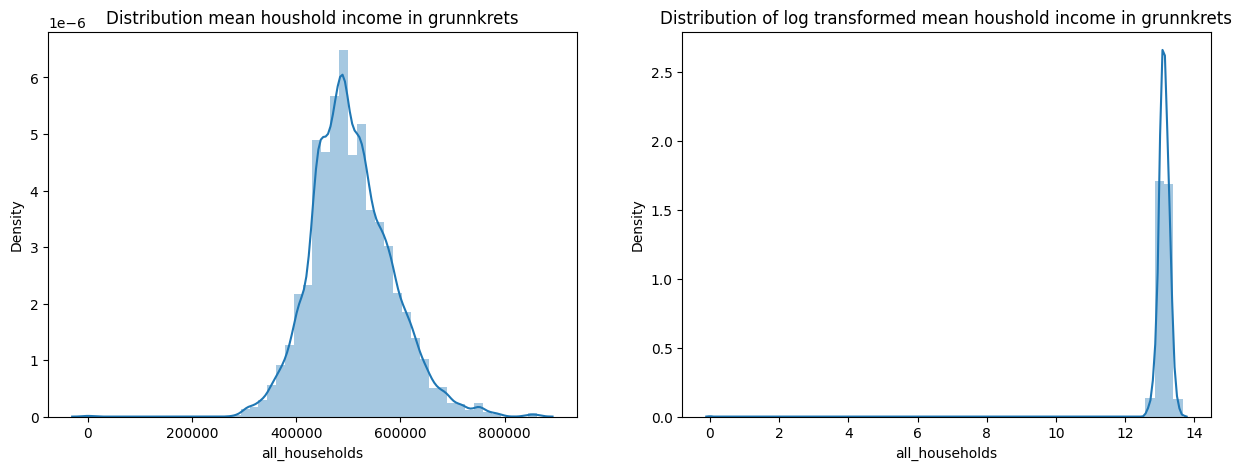

,grunnkrets_id,year,all_households,singles,couple_without_children,couple_with_children,other_households,single_parent_with_children,income_classification
0,14200105,2016,551700,270300,0,0,0,0,high
1,2311202,2015,577700,311800,0,682300,0,0,high
2,2310501,2015,668800,292500,0,842000,0,0,high
3,14200401,2016,507000,250700,0,0,0,0,medium
4,14200105,2015,539900,275800,0,710300,0,0,high


In [81]:
gk_incomes = pd.read_csv('data/grunnkrets_income_households.csv')

upper_33 = gk_incomes['all_households'].quantile(0.67)
lower_33 = gk_incomes['all_households'].quantile(0.33)
maximum = gk_incomes['all_households'].max()
gk_incomes['income_classification'] = pd.cut(gk_incomes.all_households, bins=[0,lower_33, upper_33, maximum], labels=['low','medium','high'])

fig, (ax1, ax2) = plt.subplots(figsize=(15, 5), ncols=2, dpi=100)
sns.distplot(gk_incomes['all_households'], ax=ax1);
ax1.set_title('Distribution mean houshold income in grunnkrets');
sns.distplot(np.log1p(gk_incomes['all_households']), ax=ax2);
ax2.set_title('Distribution of log transformed mean houshold income in grunnkrets');
plt.show()


gk_incomes.head()

The plot below tries to illustrate top and bottom 20% distribution of household income, however it is somewhat imprecise as the data is plotted as its own distribution based on low, medium or high and not as a whole, just coloring based on value, but it gives a visual pinpointer anyways

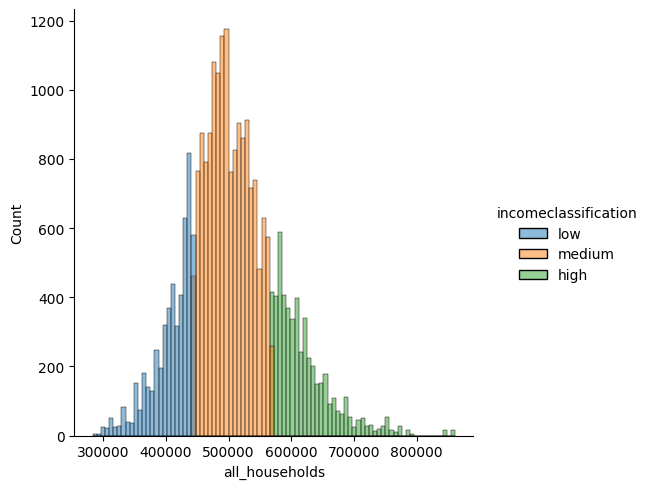

In [82]:
upper = gk_incomes['all_households'].quantile(0.80)
lower = gk_incomes['all_households'].quantile(0.20)
maximum = gk_incomes['all_households'].max()
gk_incomes['incomeclassification'] = pd.cut(gk_incomes.all_households, bins=[0,lower, upper, maximum], labels=['low','medium','high'])

sns.displot(data=gk_incomes, x='all_households', hue='incomeclassification')

In [83]:
gk_households = pd.read_csv('data/grunnkrets_households_num_persons.csv')
gk_households.head()

,grunnkrets_id,year,couple_children_0_to_5_years,couple_children_18_or_above,couple_children_6_to_17_years,couple_without_children,single_parent_children_0_to_5_years,single_parent_children_18_or_above,single_parent_children_6_to_17_years,singles
0,12010509,2015,0,0,4,0,0,0,0,4
1,14390206,2015,0,7,0,0,0,0,0,3
2,18040514,2015,10,0,0,0,0,0,0,7
3,18040804,2015,0,0,0,0,0,0,0,0
4,18200101,2015,0,6,0,0,0,0,0,4


In [84]:
gk_ages = pd.read_csv('data/grunnkrets_age_distribution.csv')
gk_ages.head()

,grunnkrets_id,year,age_0,age_1,age_2,age_3,age_4,age_5,age_6,age_7,...,age_81,age_82,age_83,age_84,age_85,age_86,age_87,age_88,age_89,age_90
0,16013117,2015,14,14,14,14,13,13,12,11,...,0,0,0,0,0,0,0,0,0,0
1,16013117,2016,10,10,10,10,10,10,9,9,...,0,0,0,0,0,0,0,0,0,0
2,11030206,2015,5,5,5,5,5,4,4,3,...,0,0,0,0,0,0,0,0,0,0
3,16011203,2016,2,2,2,2,2,3,3,3,...,1,1,1,1,1,1,1,0,0,0
4,3011601,2016,7,7,7,7,6,6,5,4,...,1,1,0,0,0,0,0,0,0,0


___

# ___________ _2. Feature Engineering_ ___________
Feature engingeering organized in the following order:
- Build features
    - Pure grunnkrets features
    - Income features
    - Age / Population features
    - Household features
    - Bus features
    - store based features
- Combine features into one frame
- inspect features

In [160]:
stores_train = pd.read_csv('data/stores_train.csv')
grunnkrets = pd.read_csv('data/grunnkrets_norway_stripped.csv')
gk_incomes = pd.read_csv('data/grunnkrets_income_households.csv')
gk_households = pd.read_csv('data/grunnkrets_households_num_persons.csv')
gk_ages = pd.read_csv('data/grunnkrets_age_distribution.csv')
buss_stopps = pd.read_csv('data/busstops_norway.csv')
hierarchy = pd.read_csv('data/plaace_hierarchy.csv')

grunnkrets.drop_duplicates(subset=['grunnkrets_id'], inplace=True)
gk_incomes.drop_duplicates(subset=['grunnkrets_id'], inplace=True)
gk_households.drop_duplicates(subset=['grunnkrets_id'], inplace=True)
gk_ages.drop_duplicates(subset=['grunnkrets_id'], inplace=True)
buss_stopps.drop_duplicates(subset=['busstop_id'], inplace=True)



### Build features

Grunnkrets

In [161]:
municipality_area = grunnkrets.groupby('municipality_name').area_km2.transform('sum')
grunnkrets['municipality_area'] = municipality_area

#grunnkrets.head()

Income

In [162]:
gk_incomes.rename(columns = {'all_households':'income_gk'}, inplace = True)

# income in district
gk_districts = grunnkrets[['grunnkrets_id','district_name']]
gk_incomes = pd.merge(gk_incomes, gk_districts, how='left', on='grunnkrets_id')

income_district = gk_incomes.groupby(['district_name']).income_gk.transform('mean')
gk_incomes['income_district'] = income_district
gk_incomes['income_district_log'] = np.log1p(income_district)

# Mean revenue in district
gk_revenues = pd.DataFrame(stores_train[['grunnkrets_id','revenue']])
gk_revenues.rename(columns = {'revenue':'revenue_gk'}, inplace = True)
gk_revenues = gk_revenues.groupby('grunnkrets_id').revenue_gk.mean()
gk_incomes = pd.merge(gk_incomes, gk_revenues, how='left', on='grunnkrets_id')
#gk_incomes['revenue_gk'].fillna(0,inplace=True)
gk_incomes['mean_rev_district'] = gk_incomes.groupby(['district_name']).revenue_gk.transform('mean')
gk_incomes['mean_rev_district_log'] = np.log1p(gk_incomes['mean_rev_district'])

# label income in district as low medium high
""" upper = gk_incomes['income_district'].quantile(0.80)
lower = gk_incomes['income_district'].quantile(0.20)
maximum = gk_incomes['income_district'].max()
gk_incomes['income_classification'] = pd.cut(gk_incomes.income_district, bins=[0,lower, upper, maximum], labels=[1,2,3]) """

# label income in gk as low medium high
upper = gk_incomes['income_gk'].quantile(0.80)
lower = gk_incomes['income_gk'].quantile(0.20)
maximum = gk_incomes['income_gk'].max()
gk_incomes['income_classification'] = pd.cut(gk_incomes.income_gk, bins=[0,lower, upper, maximum], labels=['low','medium','high'])


#gk_incomes.head(5)


Ages (populations)

In [163]:
# Merge in selected columns
gk_area = grunnkrets[['grunnkrets_id','area_km2','municipality_area','municipality_name','district_name']]
gk_ages = pd.merge(gk_ages, gk_area, how='left', on='grunnkrets_id')

# Number of people features in grunnkrets
tot_people_in_gk = np.sum(gk_ages.iloc[:,np.arange(2,93,1)], axis=1)
gk_ages['tot_people_gk'] = tot_people_in_gk

# Number of people features in municipality
tot_people_in_municipality = gk_ages.groupby('municipality_name').tot_people_gk.transform('sum')
gk_ages['tot_people_municipality'] = tot_people_in_municipality

# Number of people features in district
tot_people_in_district = gk_ages.groupby('district_name').tot_people_gk.transform('sum')
gk_ages['tot_people_district'] = tot_people_in_district

# People density gk
gk_ages['people_density_gk'] = (gk_ages['tot_people_gk'] / gk_ages['area_km2'])
gk_ages['people_density_gk_log'] = np.log1p(gk_ages['tot_people_gk'] / gk_ages['area_km2'])

# People density municipality
gk_ages['people_density_municipality'] = (gk_ages['tot_people_municipality'] / gk_ages['municipality_area'])
gk_ages['people_density_municipality_log'] = np.log1p(gk_ages['tot_people_municipality'] / gk_ages['municipality_area'])

# People density district
district_area_km2 = gk_ages.groupby('municipality_name').area_km2.transform('sum')
gk_ages['district_area_km2'] = district_area_km2

gk_ages['people_density_district'] = (gk_ages['tot_people_district'] / gk_ages['district_area_km2'])
gk_ages['people_density_district_log'] = np.log1p(gk_ages['people_density_district'])

# City name
gk_ages['city'] = "none"
col_idx = gk_ages.columns.get_loc('city')
for mun in gk_ages['municipality_name'].unique():
        gk_ages.iloc[gk_ages[(gk_ages['municipality_name']==mun) & (gk_ages['tot_people_municipality']>100000)].index,[col_idx]] = mun


#gk_ages.head(5)

Households

In [164]:
gk_municipalities = grunnkrets[['grunnkrets_id','municipality_name']]

# Number of house holds grunnkrets level
gk_households['nb_households_gk']  = np.sum(gk_households.iloc[:,np.arange(2,10,1)], axis=1)
gk_households['nb_households_gk_log']  = np.log1p(gk_households['nb_households_gk'])

# Number of house holds municipality level
gk_households = pd.merge(gk_households, gk_municipalities, how='left', on='grunnkrets_id')
nb_housholds_municipality = gk_households.groupby('municipality_name').nb_households_gk.transform('sum')
gk_households['nb_households_municipality'] = nb_housholds_municipality
gk_households['nb_households_municipality_log'] = np.log1p(nb_housholds_municipality)

#gk_households.head()

In [165]:
def add_hierarchy(stores):
    chosen_hiercs = hierarchy[['plaace_hierarchy_id','lv1_desc','lv2_desc','lv3_desc']]
    stores_with_hierarchy = pd.merge(stores,chosen_hiercs, how='inner', on='plaace_hierarchy_id')
    stores['lv1_desc'] = stores_with_hierarchy['lv1_desc']
    stores['lv2_desc'] = stores_with_hierarchy['lv2_desc']
    stores['lv3_desc'] = stores_with_hierarchy['lv3_desc']

Buss features

In [166]:
# Helper function for adding lat and lon to busses
def add_latlong(buss):
    buss['lat'] = 0.0
    buss['lon'] = 0.0
    lonList = []
    latList = [] 
    for index, row in buss.iterrows():
        lon = row['geometry']
        lon = lon[6:]
        lon = lon.replace(')','')
        
        lat = lon.split()[1]
        lon = lon.split()[0]
        lon = float(lon)
        lat = float(lat) 

        lonList.append(lon)
        latList.append(lat)
        
    buss['lon'] = np.array(lonList)
    buss['lat'] = np.array(latList)

# Add lat lon to bus_stops
add_latlong(buss_stopps)

In [167]:
# Add bus features to data frame
def add_buss_feats(stores,r1=0.3,r2=5,r3=10):
    k_neighbors =1200
    minutes = 60 #minutes
    nautic = 1.852 #km
    
    buss_stopps[["lat_rad", "lon_rad"]] = np.deg2rad(buss_stopps[["lat", "lon"]])
    stores[["lat_rad", "lon_rad"]] = np.deg2rad(stores[["lat", "lon"]])
    
    # All bus stops
    tree = BallTree(buss_stopps[["lat_rad", "lon_rad"]].values, metric='haversine')

    distances, indices = tree.query(stores[["lat_rad", "lon_rad"]], k = k_neighbors)
    distances = np.rad2deg(distances) # convert back to radians
    distances_km = distances*minutes*nautic
    nb_stops_r1 = np.count_nonzero(distances_km < r1, axis=1)
    nb_stops_r2 = np.count_nonzero(distances_km < r2, axis=1)
    nb_stops_r3 = np.count_nonzero(distances_km < r3, axis=1)
    dist_closest_bus = np.min(distances_km,axis=1)
    
    stores['dist_closest_bus'] = dist_closest_bus
    stores['dist_closest_bus_transformed'] = np.log1p(dist_closest_bus*10000)
    stores['nb_stops_r1'] = nb_stops_r1
    stores['nb_stops_r2'] = nb_stops_r2
    stores['nb_stops_r3'] = nb_stops_r3
    
    # Important bus stops
    important_buss_stops = buss_stopps[buss_stopps['importance_level'] == 'Nasjonalt knutepunkt']
    
    tree = BallTree(important_buss_stops[["lat_rad", "lon_rad"]].values, metric='haversine')

    distances, indices = tree.query(stores[["lat_rad", "lon_rad"]], k = 2) #2 because we eperienced some unstability with 1
    distances = np.rad2deg(distances) # convert back to radians
    distances_km = distances*minutes*nautic
    dist_closest_important_stop = np.min(distances_km,axis=1)
    
    stores['dist_closest_important_stop'] = dist_closest_important_stop
    stores[stores['dist_closest_important_stop'] < 0.00001] = np.max(dist_closest_important_stop,axis=0)#.replace(to_replace = 0,  value= np.max(dist_closest_important_stop), inplace=True)
    
    stores['dist_closest_important_stop_transformed'] = np.log1p(dist_closest_important_stop)


Store set

In [168]:
# Add mean rev within each chain
stores_train['chain_name'].fillna('0', inplace=True)
chain_mean_rev =  stores_train.groupby(['chain_name']).revenue.transform('mean')
stores_train['mean_chain_rev'] = chain_mean_rev

chain_rev_df = stores_train[['chain_name','mean_chain_rev']]
chain_rev_df.drop_duplicates(inplace=True)



In [169]:
def self_aggregate_columns (stores):
    # Load in all datasets containg stores to make the most accurate features
    stores_ex = pd.read_csv('data/stores_extra.csv')
    stores_tr = pd.read_csv('data/stores_train.csv')
    stores_te = pd.read_csv('data/stores_test.csv')
    all_stores = stores_ex.copy()
    all_stores = all_stores.append(stores_tr)
    all_stores = all_stores.append(stores_te)
    
    minutes=60
    nautic=1.852 #km  
    #______________________________________________________________________________________________________________________________________________________
    
    # has chain
    stores['chain_name'] = stores['chain_name'].fillna('0')
    stores['has_chain'] = stores['chain_name'].apply(lambda x: 1 if x !='0' else 0)
    #______________________________________________________________________________________________________________________________________________________

    # Distance to another store
    #TODO
    # Distance to another store of same type
    #TODO
    #______________________________________________________________________________________________________________________________________________________

    # Number of similar stores in municipality
    gk_municipalities = grunnkrets[['grunnkrets_id','municipality_name']]
    stores = pd.merge(stores, gk_municipalities, how='left', on='grunnkrets_id')
    
    nb_similar_stores_municipality = stores.groupby(['municipality_name','plaace_hierarchy_id']).plaace_hierarchy_id.transform('count')
    stores['nb_similar_stores_municipality'] = nb_similar_stores_municipality
    #______________________________________________________________________________________________________________________________________________________
    
    # Closest competitors
    all_stores[["lat_rad", "lon_rad"]] = np.deg2rad(all_stores[["lat", "lon"]])
    stores[["lat_rad", "lon_rad"]] = np.deg2rad(stores[["lat", "lon"]])
    
    stores['dist_closest_comp_km'] = 0
    
    for store_type in stores['plaace_hierarchy_id'].unique():
        
        temp_all_df = all_stores.loc[all_stores['plaace_hierarchy_id']==store_type]
        temp_target_df = stores.loc[stores['plaace_hierarchy_id']==store_type, ['store_id','lat_rad','lon_rad']]
        
        if temp_target_df.shape[0] > 1:
            tree = BallTree(temp_all_df[["lat_rad", "lon_rad"]].values, metric='haversine')
            
            distances, indices = tree.query(temp_target_df[["lat_rad", "lon_rad"]], k = 2)
            
            #distances = np.rad2deg(distances) # convert back to radians #TODO this has been forgotten, check if it improves result here and at the above one 

            distances_km = distances*minutes*nautic
            
            temp_target_df["dist_closest_comp_km_temp"] =np.max(distances_km, axis=1)
            
            temp_target_df.drop(['lat_rad','lon_rad'],axis=1, inplace=True)
            stores = pd.merge(stores, temp_target_df, how='left', on='store_id')
            stores['dist_closest_comp_km_temp'].fillna(0, inplace=True)
            
            stores['dist_closest_comp_km'] = stores['dist_closest_comp_km'] + stores['dist_closest_comp_km_temp']
            stores.drop('dist_closest_comp_km_temp', axis=1, inplace=True)
    
    # closest competitor transformed
    stores['dist_closest_comp_km_transform'] = stores['dist_closest_comp_km']
    stores['dist_closest_comp_km_transform'].replace(to_replace = 0,  method='ffill', inplace=True)
    stores['dist_closest_comp_km_transform'] = np.log1p(stores['dist_closest_comp_km_transform'])#*10000)
    #______________________________________________________________________________________________________________________________________________________
    
    # Closest competitor in chain
    stores['dist_closest_chain_km'] = 0

    for chain in stores['chain_name'].unique():
        
        temp_all_df = all_stores.loc[all_stores['chain_name']==chain]
        temp_target_df = stores.loc[stores['chain_name']==chain, ['store_id','lat_rad','lon_rad']]
        
        if temp_target_df.shape[0] > 1 and temp_all_df.shape[0] > 1 :
            tree = BallTree(temp_all_df[["lat_rad", "lon_rad"]].values, metric='haversine')
            
            distances, indices = tree.query(temp_target_df[["lat_rad", "lon_rad"]], k = 2)

            distances_km = distances*minutes*nautic
            
            temp_target_df["dist_closest_chain_km_temp"] =np.max(distances_km, axis=1)
            
            temp_target_df.drop(['lat_rad','lon_rad'],axis=1, inplace=True)
            stores = pd.merge(stores, temp_target_df, how='left', on='store_id')
            stores['dist_closest_chain_km_temp'].fillna(0, inplace=True)
            
            stores['dist_closest_chain_km'] = stores['dist_closest_chain_km'] + stores['dist_closest_chain_km_temp']
            stores.drop('dist_closest_chain_km_temp', axis=1, inplace=True)

    # closest chain transformed
    stores['dist_closest_chain_km_transform'] = stores['dist_closest_chain_km']
    stores['dist_closest_chain_km_transform'].replace(to_replace = 0,  method='ffill', inplace=True)
    stores['dist_closest_chain_km_transform'] = np.log1p(stores['dist_closest_chain_km_transform'])#*10000)
    #______________________________________________________________________________________________________________________________________________________
    
    # Number of stores within range
    tree = BallTree(all_stores[["lat_rad", "lon_rad"]].values, metric='haversine')
    
    distances , indices = tree.query(stores[["lat_rad", "lon_rad"]], k = 1200)
    distances = np.rad2deg(distances) # convert back to radians
    distances_km = distances*minutes*nautic
    
    r_1 = 0.1 #km
    r_2 = 0.5 #km
    r_3 = 1 #km
    r_4 = 5 #km
    r_5 = 10 #km
    
    stores['nb_stores_r1']  = np.count_nonzero(distances_km < r_1, axis=1)
    stores['nb_stores_r2']  = np.count_nonzero(distances_km < r_2, axis=1)
    stores['nb_stores_r3']  = np.count_nonzero(distances_km < r_3, axis=1)
    stores['nb_stores_r4']  = np.count_nonzero(distances_km < r_4, axis=1)
    stores['nb_stores_r5']  = np.count_nonzero(distances_km < r_5, axis=1)
    #______________________________________________________________________________________________________________________________________________________
    
    # Number of similar stores within radius
    radiuses = [10,5,1,0.5,0.1]
    for r in radiuses:
        stores[f"nb_of_close_competitors_{r}"] = 0
        
        for store_type in stores['plaace_hierarchy_id'].unique():
            
            temp_all_df = all_stores.loc[all_stores['plaace_hierarchy_id']==store_type]
            temp_target_df = stores.loc[stores['plaace_hierarchy_id']==store_type, ['store_id','lat_rad','lon_rad']]
            
            if temp_target_df.shape[0] > 1:
                k_neighs = temp_target_df.shape[0]
                
                tree = BallTree(temp_all_df[["lat_rad", "lon_rad"]].values, metric='haversine')
                
                distances, indices = tree.query(temp_target_df[["lat_rad", "lon_rad"]], k = (k_neighs-1))
                distances = np.rad2deg(distances)
                distances_km = distances*minutes*nautic
                distances_km[distances_km > r] = 0
                
                temp_target_df[f"nb_of_close_competitors_temp_{r}"] =np.count_nonzero(distances_km, axis=1)
                
                temp_target_df.drop(['lat_rad','lon_rad'],axis=1, inplace=True)
                stores = pd.merge(stores, temp_target_df, how='left', on='store_id')
                stores[f"nb_of_close_competitors_temp_{r}"].fillna(0, inplace=True)
                
                stores[f"nb_of_close_competitors_{r}"] = stores[f"nb_of_close_competitors_{r}"] + stores[f"nb_of_close_competitors_temp_{r}"]
                stores.drop(f"nb_of_close_competitors_temp_{r}", axis=1, inplace=True)
    #______________________________________________________________________________________________________________________________________________________
    
    
    
    remove_columns(stores,['municipality_name'])# gets added later
    return stores



### Combine all features into a single dataframe

In [170]:
def add_selected_columns(df, include_bad_columns=False):
    # Add all columns
    df = self_aggregate_columns(df)
    add_buss_feats(df)
    add_hierarchy(df)
    gk = grunnkrets[['grunnkrets_id','municipality_name', 'district_name']]
    gk_i = gk_incomes[['grunnkrets_id','income_gk','income_classification','income_district','mean_rev_district','mean_rev_district_log','income_district_log','single_parent_with_children']]
    gk_h = gk_households[['grunnkrets_id','nb_households_gk','nb_households_municipality','nb_households_gk_log','nb_households_municipality_log']]
    gk_a = gk_ages[['grunnkrets_id','tot_people_gk','tot_people_district','tot_people_municipality','people_density_gk_log','people_density_municipality_log','people_density_gk','people_density_municipality','city','people_density_district','people_density_district_log']]
    chain_rev = chain_rev_df[['chain_name','mean_chain_rev']]
    
    concat = pd.merge(df, gk, how='left', on='grunnkrets_id')
    concat = pd.merge(concat, gk_i, how='left', on='grunnkrets_id')
    concat = pd.merge(concat, gk_h, how='left', on='grunnkrets_id')
    concat = pd.merge(concat, gk_a, how='left', on='grunnkrets_id')
    concat = pd.merge(concat, chain_rev, how='left', on='chain_name')
    #______________________________________________________________________________________________________________________________________________________
    
    # NaN handling
    concat['municipality_name'].fillna('0', inplace=True)
    concat['income_classification'].fillna('medium', inplace=True)
    concat['nb_similar_stores_municipality'].fillna(0, inplace=True)
    concat['income_gk'].fillna(450000, inplace=True)
    concat['city'].fillna('none', inplace=True)
    concat['people_density_district'].fillna(concat['people_density_district'].dropna().mean(), inplace=True)#the mean value
    concat['people_density_district_log'].fillna(concat['people_density_district_log'].dropna().mean(), inplace=True)        
    concat['district_name'].fillna('none', inplace=True)
    concat['mall_name'].fillna('none', inplace=True)
    concat['income_district'].fillna(466285.26671004744, inplace=True) #replace with mean value
    concat['mean_rev_district'].fillna(8.20564984134999, inplace=True) #replace with mean value
    #concat['tot_people_gk'].fillna(concat['tot_people_gk'].dropna().mean(), inplace=True)
    concat['tot_people_district'].fillna(concat['tot_people_district'].dropna().mean(), inplace=True)
    concat['tot_people_municipality'].fillna(concat['tot_people_municipality'].dropna().mean(), inplace=True)        
    concat['people_density_gk_log'].fillna(concat['people_density_gk_log'].dropna().mean(), inplace=True)
    concat['people_density_municipality_log'].fillna(concat['people_density_municipality_log'].dropna().mean(), inplace=True)
    concat['people_density_gk'].fillna(concat['people_density_gk'].dropna().mean(), inplace=True)
    concat['people_density_municipality'].fillna(concat['people_density_municipality'].dropna().mean(), inplace=True)
    concat['mean_chain_rev'].fillna(4.29, inplace=True)
    concat['single_parent_with_children'].fillna(concat['single_parent_with_children'].mean(), inplace=True)
    concat['single_parent_with_children'].mean()
    concat['grunnkrets_id'] = concat['grunnkrets_id'].astype(np.int0)
    #______________________________________________________________________________________________________________________________________________________
    
    # Select columns we want to return
    if not include_bad_columns:
        remove_columns(concat, [
                                'store_id',
                                'store_name',
                                'year',
                                'address',
                                #'sales_channel_name',
                                #'lv1_desc',
                                #'lv2_desc',
                                #'lv3_desc',
                                'grunnkrets_id',
                                'lat',
                                'lon',
                                'lat_rad',
                                'lon_rad',
                                #'chain_name',
                                #'mall_name',
                                'has_chain',
                                'municipality_name',
                                'district_name',
                                #'income_gk',
                                'income_district',
                                'income_district_log',# use unlogged column instead due to weird distribution somehow
                                #'single_parent_with_children',
                                'mean_rev_district_log', #make things alot worse on kaggle
                                'mean_rev_district',
                                'income_classification',
                                'nb_similar_stores_municipality',
                                'nb_households_gk',
                                'nb_households_gk_log',
                                'nb_households_municipality', #very ugly distributed
                                'nb_households_municipality_log',
                                'tot_people_gk',
                                'tot_people_district',
                                'tot_people_municipality', # should be removed, very poor distribution
                                'people_density_gk', # this distributibution is suuuuperweird compared in the different sets..
                                'people_density_gk_log',
                                'people_density_municipality',
                                'people_density_municipality_log',
                                #'dist_closest_bus',
                                'dist_closest_bus_transformed',
                                #'nb_stops_r1',
                                #'nb_stops_r2',
                                #'nb_stops_r3',
                                #'dist_closest_important_stop',
                                'dist_closest_important_stop_transformed',
                                #'nb_stores_r1',
                                #'nb_stores_r2',
                                #'nb_stores_r3',
                                #'nb_stores_r4',
                                #'nb_stores_r5',
                                #'mean_chain_rev',
                                #'dist_closest_comp_km',
                                'dist_closest_comp_km_transform',
                                #'dist_closest_chain_km',
                                'dist_closest_chain_km_transform',
                                #'city',
                                'people_density_district',
                                'people_density_district_log'
                                ])
    #______________________________________________________________________________________________________________________________________________________
    
    return concat
#Bokmerke

### Inspect features

In [171]:
stores_train = pd.read_csv('data/stores_train.csv')
stores_test = pd.read_csv('data/stores_test.csv')
stores_train = add_selected_columns(stores_train, include_bad_columns=False)
stores_test = add_selected_columns(stores_test, include_bad_columns=False)

In [ ]:
# Correlation plot for numerical features
sns.set(font_scale=0.5)
plt.figure(figsize=(12,5), dpi=200)
sns.heatmap(stores_train.corr(), annot=True)
plt.show()

In [ ]:
# Pair plot features
plt.figure(figsize=(12,5), dpi=200)
sns.pairplot(stores_train)
plt.show()

In [110]:
# Inspect stores_train
#print(stores_train.isnull().sum())
#print(stores_train.dtypes)


In [102]:
# Inspect stores_test
#print(stores_test.isnull().sum())
#stores_test.head(50)

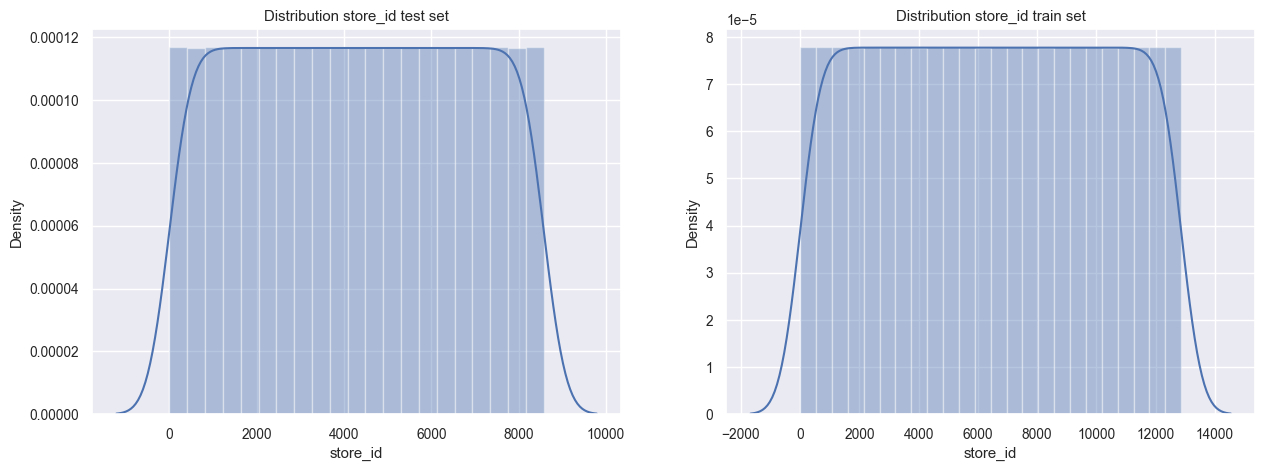

In [111]:
le = LabelEncoder()
sns.set(font_scale=0.9)
selected_cols = [
                 # change "in stores_test" below with selected_cols to only show the ones you wanna plot
                ]
for col_name in stores_test:
    
    if col_name =='income_classification':
        stores_test[col_name] = le.fit_transform(stores_test[col_name])
        stores_train[col_name] = le.fit_transform(stores_train[col_name])
            
    elif stores_test[col_name].dtypes != 'object':
        stores_test[col_name] = stores_test[col_name]
        stores_train[col_name] = stores_train[col_name]
        
    else:
        stores_test[col_name] = le.fit_transform(stores_test[col_name])
        stores_train[col_name] = le.fit_transform(stores_train[col_name])
        
    
    fig, (ax1, ax2) = plt.subplots(figsize=(15, 5), ncols=2, dpi=100)
    sns.distplot(stores_test[col_name], ax=ax1);
    ax1.set_title(f"Distribution {col_name} test set");
    sns.distplot(stores_train[col_name], ax=ax2);
    ax2.set_title(f"Distribution {col_name} train set");
    plt.show()
        
    break # comment out to show all plots


___

# ___________ _3. Machine Learning Models and Predictions_ ___________


- Define helper functions
- Model development and testing
    - LightGBM
    - CatBoost
    - XGBoost
    - Random Forest Regressor
    - H2O AutoML
- Compare the models _______________________________ (Possibly)
- Predict test and submit

### Helper functions

In [172]:
# Encode LGBM
def convert_DType_LGBM(dFrame):
    le = LabelEncoder()
    X = pd.DataFrame()
    
    for col_name in dFrame:
        if dFrame[col_name].dtypes == 'object':
            X[col_name] = dFrame[col_name].astype('category')
            
        elif col_name == 'has_chain':
            X[col_name] = dFrame[col_name].astype('category')
        
        else:
            X[col_name] = dFrame[col_name]
    return X

In [173]:
# Encode Catboost
def convert_DType_CatBoost(train_frame,train_target,test_frame=None):
    X = pd.DataFrame()
    cbe = ce.cat_boost.CatBoostEncoder()
    X = cbe.fit_transform(train_frame,train_target)
    test = cbe.transform(test_frame)
    
    return X, test

def convert_DType_CatBoost_2(train_frame,test_frame=None):
    X = pd.DataFrame()
    test = pd.DataFrame()
    
    for col_name in train_frame:
        if col_name == 'grunnkrets_id':
            X[col_name] = train_frame[col_name].astype(np.int0)
            X[col_name] = train_frame[col_name].astype('category')
        
        elif train_frame[col_name].dtypes == 'object':
            X[col_name] = train_frame[col_name].astype('category')
        
        else:
            X[col_name] = train_frame[col_name]
        
    for col_name in test_frame:
        if col_name == 'grunnkrets_id':
            test[col_name] = test_frame[col_name].astype(np.int0)
            test[col_name] = test_frame[col_name].astype('category')
        
        elif test_frame[col_name].dtypes == 'object':
            test[col_name] = test_frame[col_name].astype('category')
        
        else:
            test[col_name] = test_frame[col_name]
    
    return X, test



In [174]:
# Encode XGBoost
def convert_DType_XGBoost(dFrame):
    X = pd.DataFrame()
    le = LabelEncoder()
    for col_name in dFrame:
        
        if col_name =='income_classification':
            X[col_name] = le.fit_transform(dFrame[col_name])
            
        elif dFrame[col_name].dtypes != 'object':
            X[col_name] = dFrame[col_name]
        else:
            X[col_name] = le.fit_transform(dFrame[col_name])

    return X


In [175]:
# Encode RFR
def convert_DType_RFR(train_frame,train_target,test_frame=None):
    X = pd.DataFrame()
    cbe = ce.cat_boost.CatBoostEncoder()
    X = cbe.fit_transform(train_frame,train_target)
    test = cbe.transform(test_frame)
    
    return X, test

def convert_DType_RFR_2(dFrame, target):
    X = pd.DataFrame()
    cbe = ce.cat_boost.CatBoostEncoder()
    dFrame['income_classification'] = dFrame['income_classification'].astype('object')
    
    for col_name in dFrame:
            
        if dFrame[col_name].dtypes != 'object':
            X[col_name] = dFrame[col_name]
        else:
            X[col_name] = cbe.fit_transform(dFrame[col_name],target)
    
    
    return X

In [176]:
def get_data(test_size=0.20,include_bad_columns=False,include_submission_set=True, split_cols_revenue=True, split=True):
    stores_train = pd.read_csv('data/stores_train.csv')
    stores_test = pd.read_csv('data/stores_test.csv')

    # Add features
    stores_train = add_selected_columns(stores_train, include_bad_columns=include_bad_columns)
    if include_submission_set:
        stores_test = add_selected_columns(stores_test, include_bad_columns=include_bad_columns)

    # Divide data into train and test set
    if(split_cols_revenue):
        x_train = stores_train.drop('revenue', axis=1)
    else: 
        x_train = stores_train
    
    y_train = stores_train['revenue']
    y_train=np.log1p(y_train) #log transform revenue

    if split:
        x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=test_size, random_state=3)
        if include_submission_set:
            return  x_train, x_test, y_train, y_test, stores_test
        else:
            return  x_train, x_test, y_train, y_test
    else:
        if include_submission_set:
            return x_train, y_train, stores_test
        else:
            return x_train, y_train


### Model development and testing
Load data

In [177]:
x_train_t, x_test_t, y_train_t, y_test_t = get_data(include_submission_set=False) # t for testing
#print(x_train_t.dtypes)

LightGBM


In [ ]:
# LGBM 1
LGBM_x_train_1, LGBM_x_test_1, y_train_1, y_test_1 = x_train_t, x_test_t, y_train_t, y_test_t

# Convert to approperiate dtypes
LGBM_x_train_1 = convert_DType_LGBM(LGBM_x_train_1)
LGBM_x_test_1 = convert_DType_LGBM(LGBM_x_test_1)
categorical_features = [f for f in LGBM_x_train_1.columns if LGBM_x_train_1[f].dtype == 'category']
print(categorical_features)
print(LGBM_x_train_1.dtypes)
# Make model, fit and predict
# Params obtained trough verstack optimization in the model interpretation part and reading up on this guide: https://towardsdatascience.com/kagglers-guide-to-lightgbm-hyperparameter-tuning-with-optuna-in-2021-ed048d9838b5
#LGBM_parameters = {'learning_rate': 0.005, 'num_leaves': 97, 'colsample_bytree': 0.742655098098731, 'subsample': 0.6006487354682485, 'verbosity': -1, 'random_state': 42, 'objective': 'regression', 'metric': 'l2', 'num_threads': 6, 'reg_alpha': 0.0008764689228295414, 'min_sum_hessian_in_leaf': 2.6613399574213243, 'reg_lambda': 1.0741663161049784e-08, 'n_estimators': 1000}
LGBM_parameters = {}
    
LGBM_model_1 = LGBMRegressor(**LGBM_parameters)
LGBM_model_1.fit(LGBM_x_train_1, y_train_1,categorical_feature=categorical_features)
LGBM_pred_1 = LGBM_model_1.predict(LGBM_x_test_1)
LGBM_pred_1=np.expm1(LGBM_pred_1) #invert log transform

# Run some tests
number_of_negatives = 0
for i in range(len(LGBM_pred_1)):
    if LGBM_pred_1[i] < 0.0:
        number_of_negatives += 1
        LGBM_pred_1[i] = 0.0
print(f"number of negatives: {number_of_negatives}")
print(f"rmsle: {rmsle(y_test_1,LGBM_pred_1)}")

In [ ]:
# LGBM 2
LGBM_x_train_2, LGBM_x_test_2, y_train_2, y_test_2 = x_train_t, x_test_t, y_train_t, y_test_t

# Convert to approperiate dtypes
LGBM_x_train_2 = convert_DType_LGBM(LGBM_x_train_2, model_2=True)
LGBM_x_test_2 = convert_DType_LGBM(LGBM_x_test_2, model_2=True)
print(LGBM_x_train_2.dtypes)
# Make model, fit and predict
# Params obtained trough verstack optimization in the model interpretation part and reading up on this guide: https://towardsdatascience.com/kagglers-guide-to-lightgbm-hyperparameter-tuning-with-optuna-in-2021-ed048d9838b5
#LGBM_parameters = {'learning_rate': 0.005, 'num_leaves': 97, 'colsample_bytree': 0.742655098098731, 'subsample': 0.6006487354682485, 'verbosity': -1, 'random_state': 42, 'objective': 'regression', 'metric': 'l2', 'num_threads': 6, 'reg_alpha': 0.0008764689228295414, 'min_sum_hessian_in_leaf': 2.6613399574213243, 'reg_lambda': 1.0741663161049784e-08, 'n_estimators': 1000}
LGBM_parameters = {}
    
LGBM_model_2 = LGBMRegressor(**LGBM_parameters)
LGBM_model_2.fit(LGBM_x_train_2, y_train_2)
LGBM_pred_2 = LGBM_model_2.predict(LGBM_x_test_2)
LGBM_pred_2=np.expm1(LGBM_pred_2) #invert log transform

# Run some tests
number_of_negatives = 0
for i in range(len(LGBM_pred_2)):
    if LGBM_pred_2[i] < 0.0:
        number_of_negatives += 1
        LGBM_pred_2[i] = 0.0
print(f"number of negatives: {number_of_negatives}")
print(f"rmsle: {rmsle(y_test_2,LGBM_pred_2)}")

Catboost

In [ ]:
# Load data
CB_x_train, CB_x_test, y_train, y_test = x_train_t, x_test_t, y_train_t, y_test_t

# Convert to approperiate dtypes
#CB_x_train = convert_DType_CatBoost(CB_x_train,y_train)
#CB_x_test = convert_DType_CatBoost(CB_x_test,y_test)
CB_x_train, CB_x_test = convert_DType_CatBoost_2(CB_x_train, CB_x_test)
print(CB_x_train.dtypes)
categorical_features_indices = np.where((CB_x_train.dtypes == 'object') | (CB_x_train.dtypes == str) | (CB_x_train.dtypes == 'category'))[0]
print(categorical_features_indices)
#test_pool = cb.Pool(CB_x_test, y_test, categorical_features_indices )

# Make model, fit and predict
# params found with gridsearch in the model interpretation part and some testing on our own
#CB_parameters = {'depth': 8, 'iterations': 1500, 'learning_rate': 0.03, 'use_best_model': True}
CB_parameters = {}

CB_model = cb.CatBoostRegressor(loss_function='RMSE', **CB_parameters, verbose=0)
CB_model.fit( CB_x_train, y_train, cat_features=categorical_features_indices) #, eval_set=test_pool, use_best_model=True, plot=False)
CB_pred = CB_model.predict(CB_x_test)
CB_pred = np.expm1(CB_pred)


# Run some tests
print(f"rmsle: {rmsle(y_test,CB_pred)}")


XGBoost

In [ ]:

# Load data
XG_x_train, XG_x_test, y_train, y_test = x_train_t, x_test_t, y_train_t, y_test_t

# Convert to approperiate dtypes
XG_x_train = convert_DType_XGBoost(XG_x_train)
XG_x_test = convert_DType_XGBoost(XG_x_test)

print(XG_x_train.dtypes)

# Make model, fit and predict
XG_parameters = {}

XG_model = xg.XGBRegressor(**XG_parameters)#,tree_method="gpu_hist", enable_categorical=True)
XG_model.fit(XG_x_train,y_train)
XG_pred = XG_model.predict(XG_x_test)
XG_pred = np.expm1(XG_pred)


# Run some tests
number_of_negatives = 0
for i in range(len(XG_pred)):
    if XG_pred[i] < 0.0:
        number_of_negatives += 1
        XG_pred[i] = 0.0

print(f"number of negatives: {number_of_negatives}")
print(f"rmsle: {rmsle(y_test,XG_pred)}")

Random forest regressor

In [ ]:
RFR_x_train, RFR_x_test, y_train, y_test = x_train_t, x_test_t, y_train_t, y_test_t

RFR_parameters = {}

RFR_model = RandomForestRegressor(**RFR_parameters)
RFR_x_train = convert_DType_RFR_2(RFR_x_train,y_train)
RFR_x_test = convert_DType_RFR_2(RFR_x_test,y_test)
#RFR_x_train, RFR_x_test = convert_DType_RFR(RFR_x_train, y_train, RFR_x_test)

RFR_model.fit(RFR_x_train, y_train_t)

RFR_pred = RFR_model.predict(RFR_x_test)
RFR_pred = np.expm1(RFR_pred)



print(f"rmsle: {rmsle(y_test,RFR_pred)}")

rmsle: 0.9051227365816644


AutoML

In [123]:


""" from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.automl import H2OAutoML
h2o.init()

# import the boston dataset:
# this dataset looks at features of the boston suburbs and predicts median housing prices
# the original dataset can be found at https://archive.ics.uci.edu/ml/datasets/Housing
##boston = h2o.import_file("https://s3.amazonaws.com/h2o-public-test-data/smalldata/gbm_test/BostonHousing.csv")

#pandah2_x_train, pandah2_x_test, y_train, y_test, _ = get_data(dropRevenueCol = False)


dfh2 = h2o.H2OFrame(stores_train)
dftesting = h2o.H2OFrame(stores_test)



input_datatypes = {'key': 'datatype', ...


}





#dfh2 = h2o.import_file("data/stores_train.csv")
#dftesting = h2o.import_file("data/stores_test.csv")

# set the predictor columns
##predictors = boston.columns[:-1]
predsh2 = dfh2.columns[:-1]


# this example will predict the medv column
# you can run the following to see that medv is indeed a numeric value
##boston["medv"].isnumeric()
#fh2["revenue"].isnumeric()

# set the response column to "medv", which is the median value of owner-occupied homes in $1000's
##response = "medv"
resp = "revenue"


H2O

log rev


rmse lokal test


# convert the `chas` column to a factor
# `chas` = Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
##boston['chas'] = boston['chas'].asfactor()

# split into train and testing sets
##train, test = boston.split_frame(ratios = [0.8], seed = 1234)

#training, training2 = dfh2.split_frame(ratios = [0.9], seed = 1234)
#testing, testing2 = dftesting.split_frame(ratios = [0.9], seed =  1234)
training = dfh2
testing = dftesting
#training, testing = dfh2.split_frame(ratios = [0.8], seed = 1234)

# set the `alpha` parameter to 0.25
# then initialize the estimator then train the model
##boston_glm = H2OGeneralizedLinearEstimator(alpha = 0.25)
## boston_glm.train(x = predictors, y = response, training_frame = train)


## Auto ML
dfh2_auto = H2OAutoML(max_models=50, nfolds=6,  seed=2, stopping_metric="RMSE", exclude_algos="DeepLearning")
dfh2_auto.train(x = predsh2, y = resp, training_frame = training)
predictionsh2 = dfh2_auto.predict(testing)



## GLE
dfh2_glm = H2OGeneralizedLinearEstimator(alpha = 0.25)
dfh2_glm.train(x = predsh2, y = resp, training_frame = training)
predictionsh2 = dfh2_glm.predict(testing)

# predict using the model and the testing dataset
#predict = boston_glm.predict(test)




# View a summary of the prediction
print("det funka gitt") """;

### Compare models - [Depricated]

In [122]:
# Depricated
def compare_preds_func():
    """ compare_preds = pd.DataFrame()
    compare_preds['true'] = y_test
    compare_preds['median'] = np.median([CB_pred,LGBM_pred,XG_pred],axis=0)
    compare_preds['mean'] = np.mean([CB_pred,LGBM_pred,XG_pred],axis=0)
    compare_preds['catboost'] = CB_pred
    compare_preds['lightgbm'] = LGBM_pred
    compare_preds['XGBoost'] = XG_pred
    compare_preds['Median err'] = np.abs(np.median([CB_pred,LGBM_pred,XG_pred],axis=0) - y_test)
    compare_preds['Mean err'] = np.abs(np.mean([CB_pred,LGBM_pred,XG_pred],axis=0) - y_test)
    compare_preds['CB err'] = np.abs(CB_pred - y_test)
    compare_preds['LGBM err'] = np.abs(LGBM_pred - y_test)
    compare_preds['XG err'] = np.abs(XG_pred - y_test)

    
    print(f" Sum Err Mean:   {np.sum(compare_preds['Mean err'])}")
    print(f" Sum Err Median: {np.sum(compare_preds['Median err'])}")
    print(f" Sum Err CB:     {np.sum(compare_preds['CB err'])}")
    print(f" Sum Err LGBM:   {np.sum(compare_preds['LGBM err'])}")
    print(f" Sum Err XG :    {np.sum(compare_preds['XG err'])}")

    print(f" Mean Err Mean:   {np.mean(compare_preds['Mean err'])}")
    print(f" Mean Err Median: {np.mean(compare_preds['Median err'])}")
    print(f" Mean Err CB:     {np.mean(compare_preds['CB err'])}")
    print(f" Mean Err LGBM:   {np.mean(compare_preds['LGBM err'])}")
    print(f" Mean Err XG:     {np.mean(compare_preds['XG err'])}")

    print(f" RSMLE mean:      {rmsle(y_test, ((CB_pred + LGBM_pred + XG_pred)/3))}")
    print(f" RSMLE Median:    {rmsle(y_test, np.median([CB_pred,LGBM_pred,XG_pred],axis=0))}")
    print(f" RSMLE LGBM:      {rmsle(y_test, LGBM_pred)}")
    print(f" RSMLE CB:        {rmsle(y_test, CB_pred)}")
    print(f" RSMLE XG:        {rmsle(y_test, XG_pred)}")

    print(f" \n Combos")
    print(f" RSMLE CB & LGBM:    {rmsle(y_test, ((CB_pred + LGBM_pred)/2))}")
    print(f" RSMLE CB & XG:      {rmsle(y_test, ((CB_pred + XG_pred)/2))}")
    print(f" RSMLE XG & LGBM:    {rmsle(y_test, ((LGBM_pred + XG_pred)/2))}")
    print(f" RSMLE Mean:         {rmsle(y_test, ((CB_pred + LGBM_pred + XG_pred)/3))}")
    print(f" RSMLE Median:       {rmsle(y_test, np.median([CB_pred,LGBM_pred,XG_pred],axis=0))}")
    print()
    print(f" Sum Err CB & LGBM:  {np.sum(np.abs((CB_pred+LGBM_pred)/2 - y_test))}")
    print(f" Sum Err CB & XG:    {np.sum(np.abs((CB_pred+XG_pred)/2 - y_test))}")
    print(f" Sum Err XG & LGBM:  {np.sum(np.abs((LGBM_pred+XG_pred)/2 - y_test))}")
    print(f" Sum Err Mean:       {np.sum(np.abs((CB_pred+LGBM_pred+XG_pred)/3 - y_test))}")
    print(f" Sum Err Median:     {np.sum(np.abs(np.median([CB_pred,LGBM_pred,XG_pred],axis=0) - y_test))}")
    print()
    print(f" Mean Err CB & LGBM: {np.mean(np.abs((CB_pred+LGBM_pred)/2 - y_test))}")
    print(f" Mean Err CB & XG:   {np.mean(np.abs((CB_pred+XG_pred)/2 - y_test))}")
    print(f" Mean Err XG & LGBM: {np.mean(np.abs((LGBM_pred+XG_pred)/2 - y_test))}")
    print(f" Mean Err mean:      {np.mean(np.abs((CB_pred+LGBM_pred+XG_pred)/3 - y_test))}")
    print(f" Mean Err Median:    {np.mean(np.abs(np.median([CB_pred,LGBM_pred,XG_pred],axis=0) - y_test))}") """

#compare_preds_func()

### Predict test and submit

In [124]:
CB_parameters = {}#'depth': 12, 'iterations': 3000, 'learning_rate': 0.002, 'use_best_model': True}
LGBM_parameters = {}#'learning_rate': 0.002, 'n_estimators': 2000}

In [ ]:
# Load data
#x_train, x_test, y_train, y_test, test = get_data(test_size=0.0001)
x_train, y_train, test = get_data(split=False)
print(x_train.columns)

# Convert to approperiate dtypes
LGBM_x_train_1 = convert_DType_LGBM(x_train)
LGBM_test_1 = convert_DType_LGBM(test)
categorical_features = [f for f in LGBM_x_train_1.columns if LGBM_x_train_1[f].dtype == 'category']

""" LGBM_x_train_2 = convert_DType_LGBM(x_train, model_2=True)
LGBM_test_2 = convert_DType_LGBM(test, model_2=True) """

#CB_x_train,CB_test = convert_DType_CatBoost(x_train, y_train, test)
CB_x_train, CB_test = convert_DType_CatBoost_2(x_train, test)
categorical_features_indices = np.where((CB_x_train.dtypes == 'object') | (CB_x_train.dtypes == str) | (CB_x_train.dtypes == 'category'))[0]

XG_x_train = convert_DType_XGBoost(x_train)
XG_test = convert_DType_XGBoost(test)

# Confirm correct feats
print(f"LGBM:\n{LGBM_x_train_1.dtypes}\n")
print(f"CB:\n{categorical_features_indices}\n{CB_x_train.dtypes}\n")
print(f"XG:\n{XG_x_train.dtypes}\n")

# LGBM_1
LGBM_model_1 = LGBMRegressor(**LGBM_parameters)
LGBM_model_1.fit(LGBM_x_train_1, y_train, categorical_feature=categorical_features)
LGBM_pred_1 = LGBM_model_1.predict(LGBM_test_1)
#LGBM_pred=np.expm1(LGBM_pred) #invert log transform

""" # LGBM_2
LGBM_model_2 = LGBMRegressor(**LGBM_parameters)
LGBM_model_2.fit(LGBM_x_train_2, y_train)
LGBM_pred_2 = LGBM_model_2.predict(LGBM_test_2) """


# Catboost
CB_model = cb.CatBoostRegressor(loss_function='RMSE', **CB_parameters, silent=True)
CB_model.fit(CB_x_train,y_train, cat_features=categorical_features_indices)
CB_pred = CB_model.predict(CB_test)
#CB_pred = np.expm1(CB_pred)
""" 
# XGBoost
XG_model = xg.XGBRegressor(**XG_parameters)
XG_model.fit(XG_x_train,y_train)
XG_pred = XG_model.predict(XG_test)
XG_pred = np.expm1(XG_pred) """

# Aggregate result
PREDICTION = np.expm1(CB_pred)

In [ ]:
#write the predicition to file
stores_test = pd.read_csv('data/stores_test.csv')
writeResultToFile(stores_test, PREDICTION, "CB_weird_encode")

# Verify format of submission file
submissionVery = pd.read_csv('submissionFiles/CB_weird_encode.csv')
submissionVery.info()

# ___________ _4. Model Interpretations_ ___________

- Parameter optimization
    - Verstack parameter importance for LGBM
    - Gridsearch for CatBoost parameters
- Feature importance
    - CatBoost
    - LightGBM
    - XGBoost
- Shap values
    - CatBoost

In [125]:
# Load data set
x_train, x_test, y_train, y_test = get_data(include_bad_columns=False,include_submission_set=False)

### Parameter Optimization


#### Lightgbm

In [ ]:
LGBM_x_train = convert_DType_LGBM(x_train)
cat_columns = LGBM_x_train.select_dtypes(['category']).columns
LGBM_x_train[cat_columns] = LGBM_x_train[cat_columns].apply(lambda x: pd.factorize(x)[0])

sns.set(font_scale=1)
tuner = LGBMTuner(metric = 'rmsle', verbosity=0);
tuner.fit(LGBM_x_train, y_train);


CatBoost

In [ ]:
# Gridsearch best hyperparameters
CB_x_train, CB_x_test = convert_DType_CatBoost(x_train, y_train, x_test)

categorical_features_indices = np.where((CB_x_train.dtypes == 'object') | (CB_x_train.dtypes == str) | (CB_x_train.dtypes == 'category') )[0]
test_pool = cb.Pool(CB_x_test, y_test, categorical_features_indices )
CB_model = cb.CatBoostRegressor(loss_function='RMSE', verbose=0, cat_features=categorical_features_indices)

grid = {'iterations': [2000],
        'learning_rate': [0.005, 0.01],
        'depth': [8, 10, 12, 13],
        'use_best_model': [True]}
""" grid = GridSearchCV(estimator=CB_model, param_grid=grid, cv=2, n_jobs=1, verbose=0)
grid.fit(CB_x_train, y_train, eval_set=test_pool)"""

' grid = GridSearchCV(estimator=CB_model, param_grid=grid, cv=2, n_jobs=1, verbose=0)\ngrid.fit(CB_x_train, y_train, eval_set=test_pool)'

#### Print Best parameters

In [ ]:
print(f" \n Best params LGBM: {tuner.best_params}\n")
#print(f" Best params CB: {grid.best_params_}")

### Feature importance

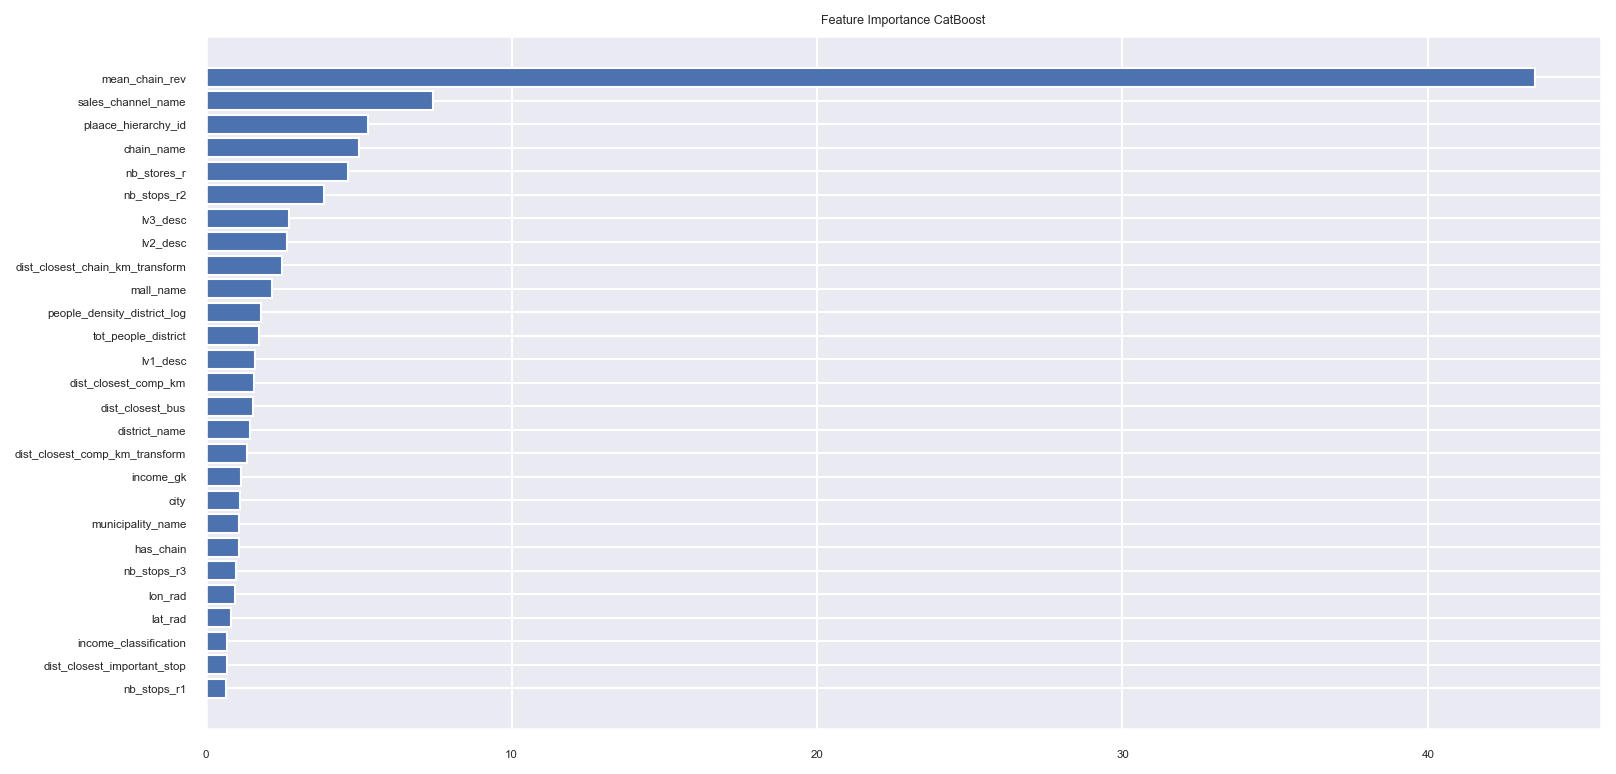

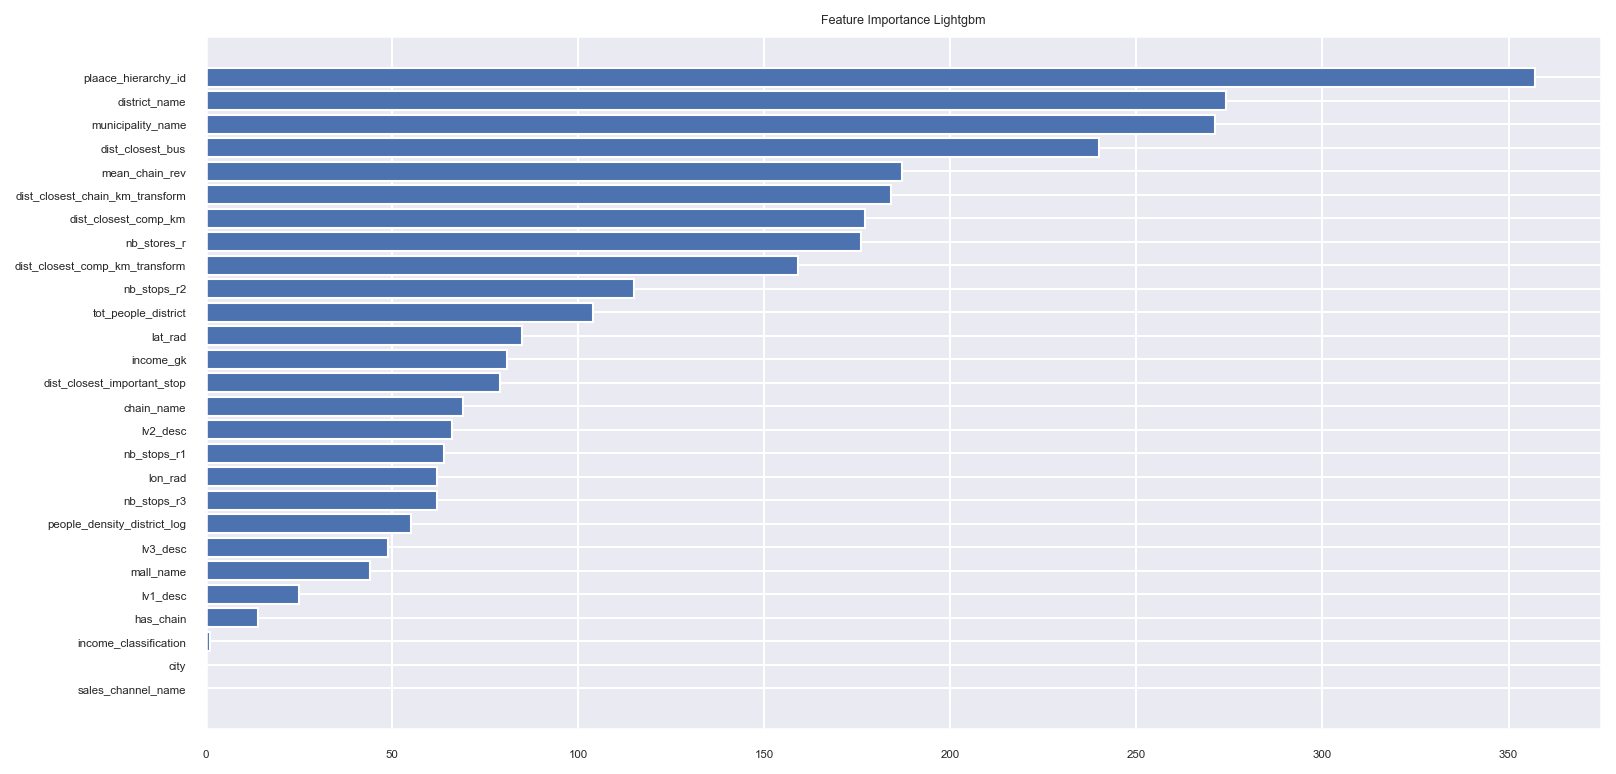

NameError: name 'XG_model' is not defined

In [ ]:
# Feature importance

# lightGBM
#tuner.plot_importances()

# catBoost
CB_model = cb.CatBoostRegressor(loss_function='RMSE', verbose=0, cat_features=categorical_features_indices)
CB_model.fit(CB_x_train, y_train, eval_set=test_pool)

# CatBoost
CB_f_imp = CB_model.feature_importances_
sorted_idx = np.argsort(CB_f_imp)

fig = plt.figure(figsize=(12, 6), dpi=150)
plt.barh(range(len(sorted_idx)), CB_f_imp[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(CB_x_train.columns)[sorted_idx])
plt.title('Feature Importance CatBoost')
plt.show()

# LightGBM
LGBM_x_train = convert_DType_LGBM(x_train)
categorical_features = [f for f in LGBM_x_train.columns if LGBM_x_train[f].dtype == 'category']
LGBM_model = lgb.LGBMRegressor()#**LGBM_parameters)
LGBM_model.fit(LGBM_x_train, y_train, categorical_feature=categorical_features)

LGBM_f_imp = LGBM_model.feature_importances_
sorted_idx = np.argsort(LGBM_f_imp)

fig = plt.figure(figsize=(12, 6), dpi=150)
plt.barh(range(len(sorted_idx)), LGBM_f_imp[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(LGBM_x_train.columns)[sorted_idx])
plt.title('Feature Importance Lightgbm')
plt.show()

# XGBoost
""" XG_f_imp = XG_model.feature_importances_
sorted_idx = np.argsort(XG_f_imp)

fig = plt.figure(figsize=(12, 6), dpi=150)
plt.barh(range(len(sorted_idx)), XG_f_imp[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(XG_x_train.columns)[sorted_idx])
plt.title('Feature Importance XGBoost')
plt.show() """;
#bokmerke


### shap

In [ ]:
shap.initjs()

In [ ]:
explainer = shap.TreeExplainer(CB_model)
shap_values = explainer.shap_values(CB_x_train)
row=1

In [ ]:
row+=1
shap.force_plot(explainer.expected_value, shap_values[row,:], CB_x_train.iloc[row,:])


In [ ]:
#shap.summary_plot(shap_values, CB_x_train)
shap.summary_plot(shap_values, CB_x_train, show=False, color_bar=False)
plt.show()

# End of Notebook